In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# update cpi if flagged out of date
# cpi.update()

In [2]:
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='winter_r')

In [3]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query function
def fetcha(q):
    return cur.execute(q).fetchall()

In [4]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [5]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [6]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [7]:
# creating initial dataframe by joining the numbers and rotten tomatoes tables 
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
dfr = pd.DataFrame(fetcha(q))
dfr.columns = [i[0] for i in cur.description]   

In [8]:
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [9]:
dfr.isna().sum()

idx                                   0
rotten_tomatoes_link                  0
movie_title                           0
movie_info                           35
critics_consensus                   642
content_rating                        0
genres                                0
directors                            52
authors                             119
actors                               14
original_release_date                64
streaming_release_date               38
runtime                              35
production_company                   17
tomatometer_status                    3
tomatometer_rating                    3
tomatometer_count                     3
audience_status                      31
audience_rating                      12
audience_count                       13
tomatometer_top_critics_count         0
tomatometer_fresh_critics_count       0
tomatometer_rotten_critics_count      0
idx                                   0
id                                    0


In [10]:
# changing name NaNs to strings
dfr['actors'] = dfr['actors'].fillna('NaN')
dfr['directors'] = dfr['directors'].fillna('NaN')
dfr['authors'] = dfr['authors'].fillna('NaN')
dfr['production_company'] = dfr['production_company'].fillna('NaN')

In [11]:
# change date string to datetime object 
dfr.release_date = pd.to_datetime(dfr.release_date)
dfr['year'] = dfr['release_date'].apply(lambda x: x.year)
dfr['month'] = dfr['release_date'].apply(lambda x: x.month)

In [12]:
#cleaning numerical strings and converting to floats
dfr['worldwide_gross'] = dfr['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['domestic_gross'] = dfr['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['production_budget'] = dfr['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [13]:
# adding intl gross column
dfr['international_gross'] = dfr['worldwide_gross'].sub(dfr['domestic_gross'])

In [14]:
# adding net profit columns
dfr['domestic_net'] = dfr['domestic_gross'].sub(dfr['production_budget'])
dfr['worldwide_net'] = dfr['worldwide_gross'].sub(dfr['production_budget'])
dfr['international_net'] = dfr['international_gross'].sub(dfr['production_budget'])

In [15]:
# adding roi columns
dfr['domestic_roi'] = dfr['domestic_net'].divide(dfr['production_budget'])
dfr['worldwide_roi'] = dfr['worldwide_net'].divide(dfr['production_budget'])
dfr['international_roi'] = dfr['international_net'].divide(dfr['production_budget'])

In [16]:
dfr#adding adjust gross profit and budget columns
dfr['adj_dom_gross'] = dfr.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
dfr['adj_ww_gross'] = dfr.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
dfr['adj_i_gross'] = dfr.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
dfr['adj_prod_budg'] = dfr.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)

In [17]:
#adding net profit columns
dfr['adj_dom_net'] = dfr['adj_dom_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_ww_net'] = dfr['adj_ww_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_i_net'] = dfr['adj_i_gross'].sub(dfr['adj_prod_budg'])

In [18]:
#adding adjusted return on investment columns and checking results
dfr['adj_dom_roi'] = dfr['adj_dom_net'].divide(dfr['adj_prod_budg'])
dfr['adj_ww_roi'] = dfr['adj_ww_net'].divide(dfr['adj_prod_budg'])
dfr['adj_i_roi'] = dfr['adj_i_net'].divide(dfr['adj_prod_budg'])
dfr.head(1)

idx rotten_tomatoes_link  \
0    0            m/0814255   

                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   

                                   critics_consensus content_rating  \
0  Though it may seem like just another Harry Pot...             PG   

                                              genres       directors  \
0  Action & Adventure, Comedy, Drama, Science Fic...  Chris Columbus   

                                      authors  \
0  Craig Titley, Chris Columbus, Rick Riordan   

                                              actors  ... adj_dom_gross  \
0  Logan Lerman, Brandon T. Jackson, Alexandra Da...  ...  1.040753e+08   

   adj_ww_gross   adj_i_gross adj_prod_budg   adj_dom_net    adj_ww_net  \
0  2.615132e+08  1.574379e+08  1.113815e+08 -7.306274e+06  1.501316e+08   

      adj_i_net adj_dom_roi  adj_ww_roi  adj_i_roi  
0  4.605635e+07   -0.065597    1.347904   0.413501  

[1 rows x 49 columns]

In [19]:
# checking column names
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [20]:
# renaming columns
dfr = dfr.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

## Top 100 Films by Worldwide Gross

In [21]:
# creating dataframes sorted by gross
title_gross = dfr[['title', 'production_budget', 'worldwide_gross',\
                   'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top20_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(20)

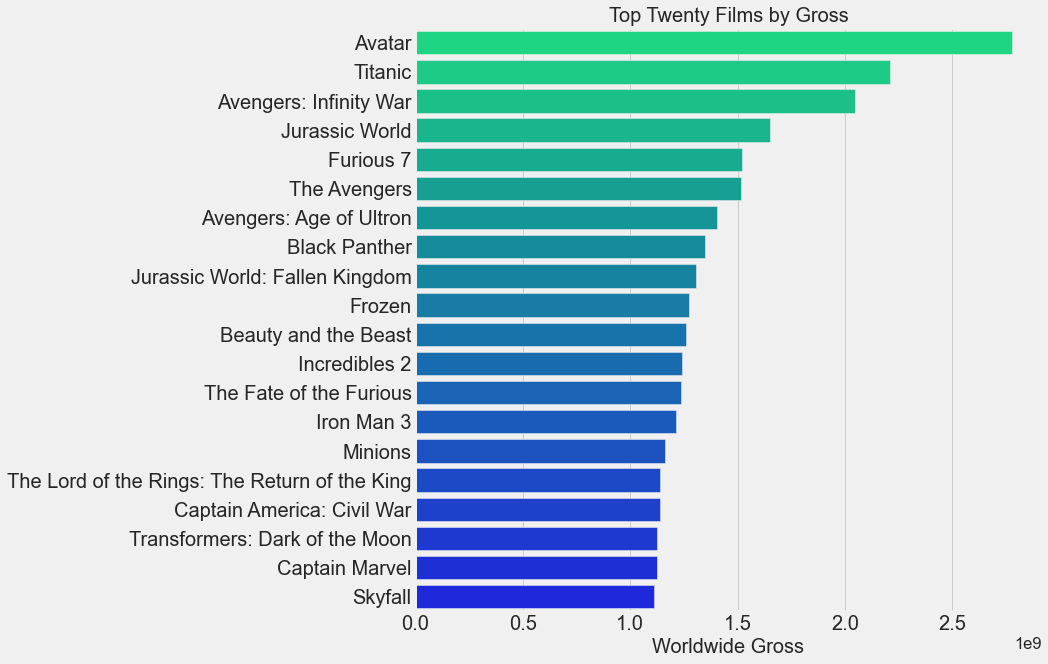

In [22]:
# plotting top 20 films by gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_gross', y='title', data= top20_gross_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Gross', size = 20)
plt.show()

In [23]:
# top 100 by gross basic stats
print(f'mean budget {top100_gross_films.production_budget.mean()}')
print(f'median budget {top100_gross_films.production_budget.median()}')
print(f'min budget {top100_gross_films.production_budget.min()}')
print(f'max budget {top100_gross_films.production_budget.max()}')
top100_gross_films.describe()

mean budget 168575000.0
median budget 172500000.0
min budget 35000000.0
max budget 425000000.0


production_budget  worldwide_gross  worldwide_net  worldwide_roi  \
count       1.000000e+02     1.000000e+02   1.000000e+02     100.000000   
mean        1.685750e+08     9.576570e+08   7.890820e+08       5.846388   
std         7.397127e+07     3.273300e+08   3.019174e+08       3.688244   
min         3.500000e+07     6.522201e+08   3.559452e+08       1.186484   
25%         1.100000e+08     7.578371e+08   6.014434e+08       3.236404   
50%         1.725000e+08     8.794230e+08   7.003720e+08       4.513429   
75%         2.000000e+08     1.040525e+09   8.783895e+08       7.029846   
max         4.250000e+08     2.776345e+09   2.351345e+09      18.927371   

              year       month  
count   100.000000  100.000000  
mean   2011.340000    7.250000  
std       6.067333    2.903759  
min    1993.000000    2.000000  
25%    2009.000000    5.000000  
50%    2013.000000    6.000000  
75%    2016.000000   11.000000  
max    2019.000000   12.000000

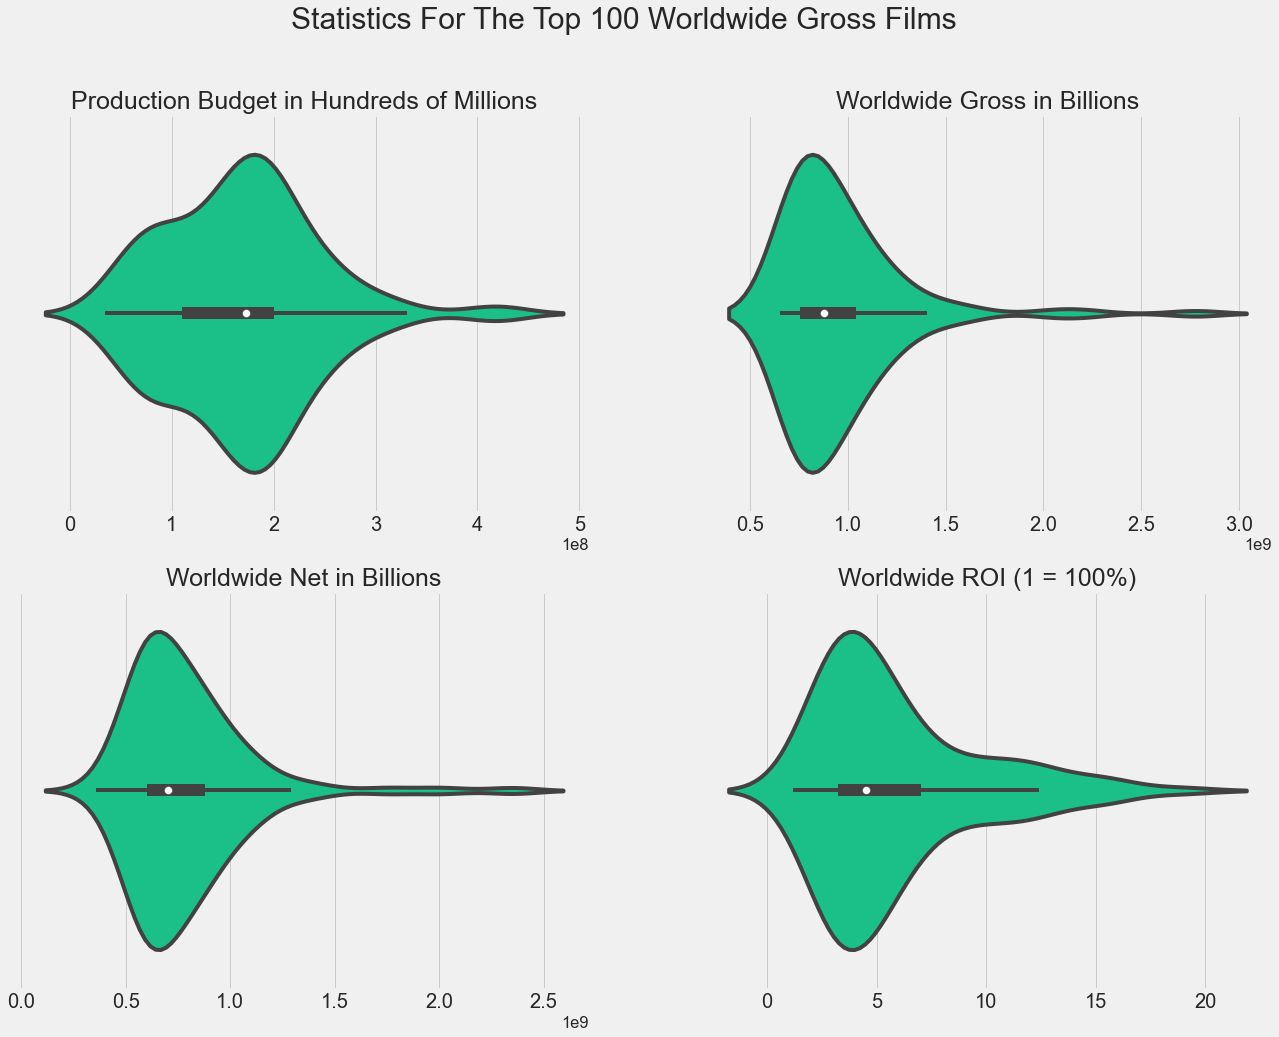

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('Statistics For The Top 100 Worldwide Gross Films', size=30)
sns.violinplot(ax=axes[0, 0], x='production_budget', data=top100_gross_films,)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=top100_gross_films)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=top100_gross_films)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=top100_gross_films)
axes[0, 0].set_title('Production Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20) 
plt.show()

|Budget Stat       |Dollar Amount      |
|:-----------------|------------------:|
|Mean Budget       |       168,575,000 |
|Median Budget     |       172,500,000 |
|Min Budget        |        35,000,000 |
|Max Budget        |        425,000,000|

In [25]:
# creating dataframes sorted by adjusted gross
title_adj_gross = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                       'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.drop_duplicates(subset = ['title'])
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)

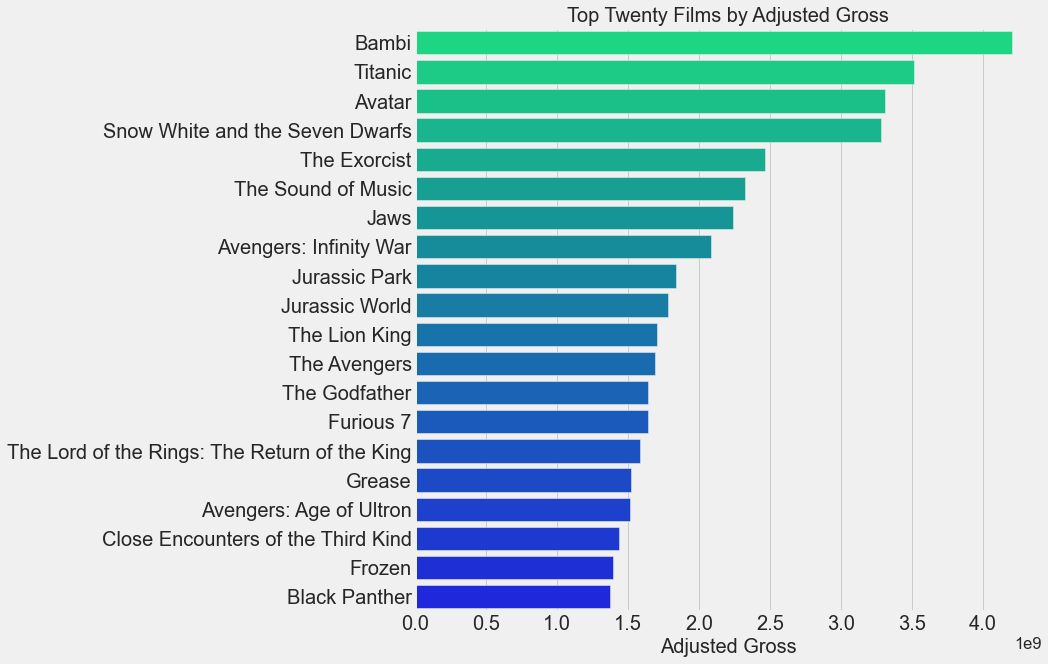

In [26]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_gross', y='title', data= top20_adj_gross_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted Gross", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Adjusted Gross', size = 20)
plt.show()

In [27]:
# top 100 by adjusted gross basic stats
print(f'mean {top100_adj_gross_films.adj_prod_budg.mean()}')
print(f'median {top100_adj_gross_films.adj_prod_budg.median()}')
print(f'min {top100_adj_gross_films.adj_prod_budg.min()}')
print(f'max {top100_adj_gross_films.adj_prod_budg.max()}')
top100_adj_gross_films.describe()

mean 168748084.47432208
median 179232282.51574492
min 4493093.145869947
max 506459142.2458597


adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi         year  \
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000   100.000000   
mean    1.687481e+08  1.277631e+09  1.108883e+09   16.019202  2001.810000   
std     9.581017e+07  5.732113e+08  5.769721e+08   39.681137    17.395399   
min     4.493093e+06  8.547247e+08  6.252047e+08    1.546673  1937.000000   
25%     8.805160e+07  9.490569e+08  8.062123e+08    4.006988  1994.000000   
50%     1.792323e+08  1.115988e+09  9.634766e+08    5.697061  2008.500000   
75%     2.201631e+08  1.304167e+09  1.156453e+09   11.970308  2015.000000   
max     5.064591e+08  4.203440e+09  4.189983e+09  311.354312  2019.000000   

            month  
count  100.000000  
mean     7.580000  
std      3.012365  
min      2.000000  
25%      5.000000  
50%      7.000000  
75%     11.000000  
max     12.000000

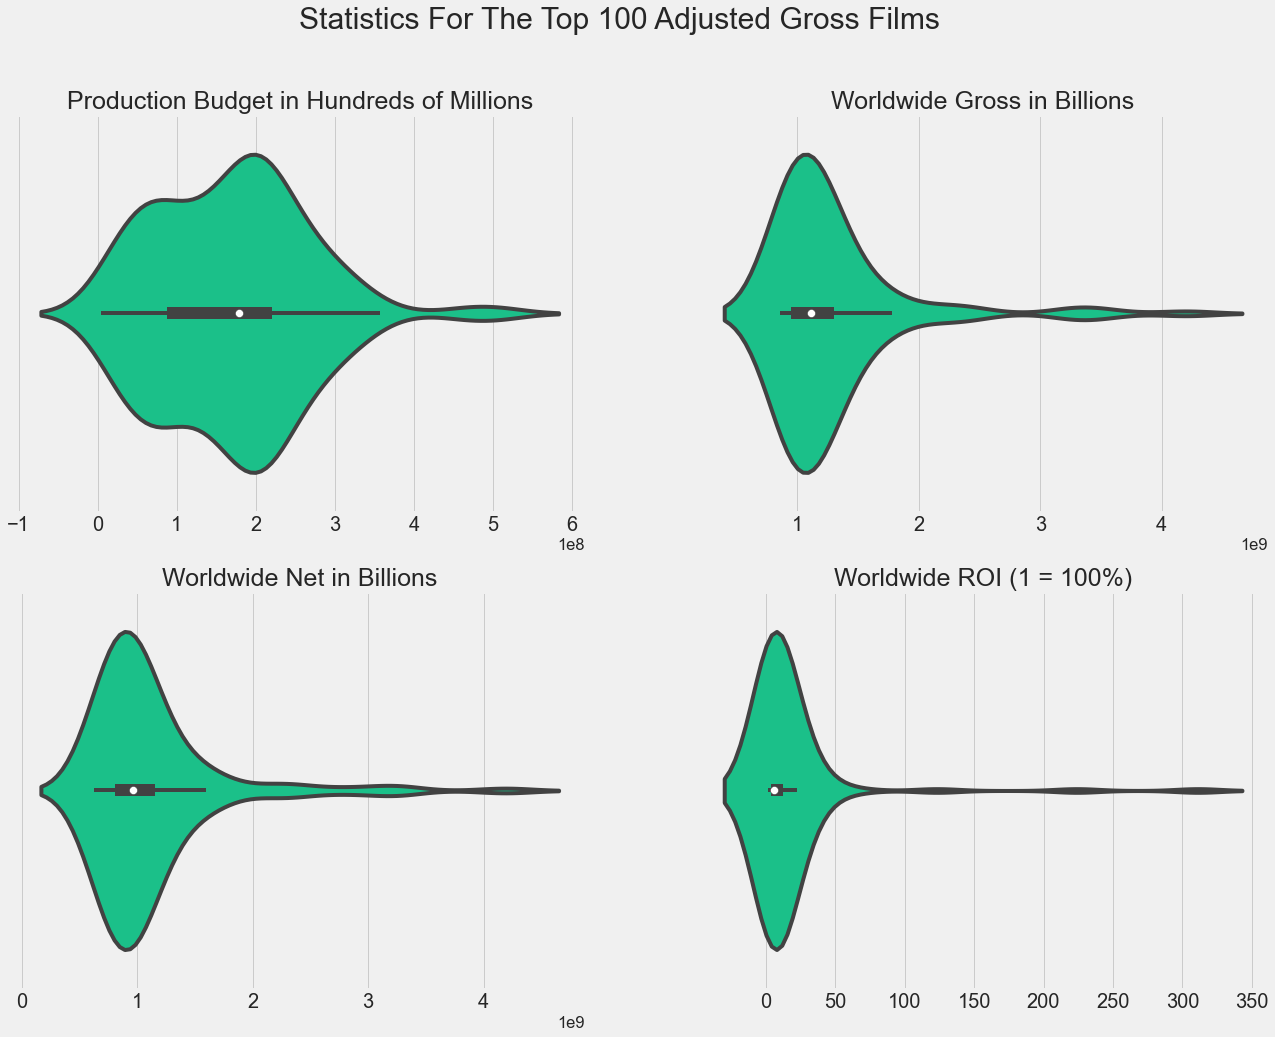

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('Statistics For The Top 100 Adjusted Gross Films', size=30)
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=top100_adj_gross_films)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=top100_adj_gross_films)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=top100_adj_gross_films)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=top100_adj_gross_films)
axes[0, 0].set_title('Production Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20) 
plt.show()

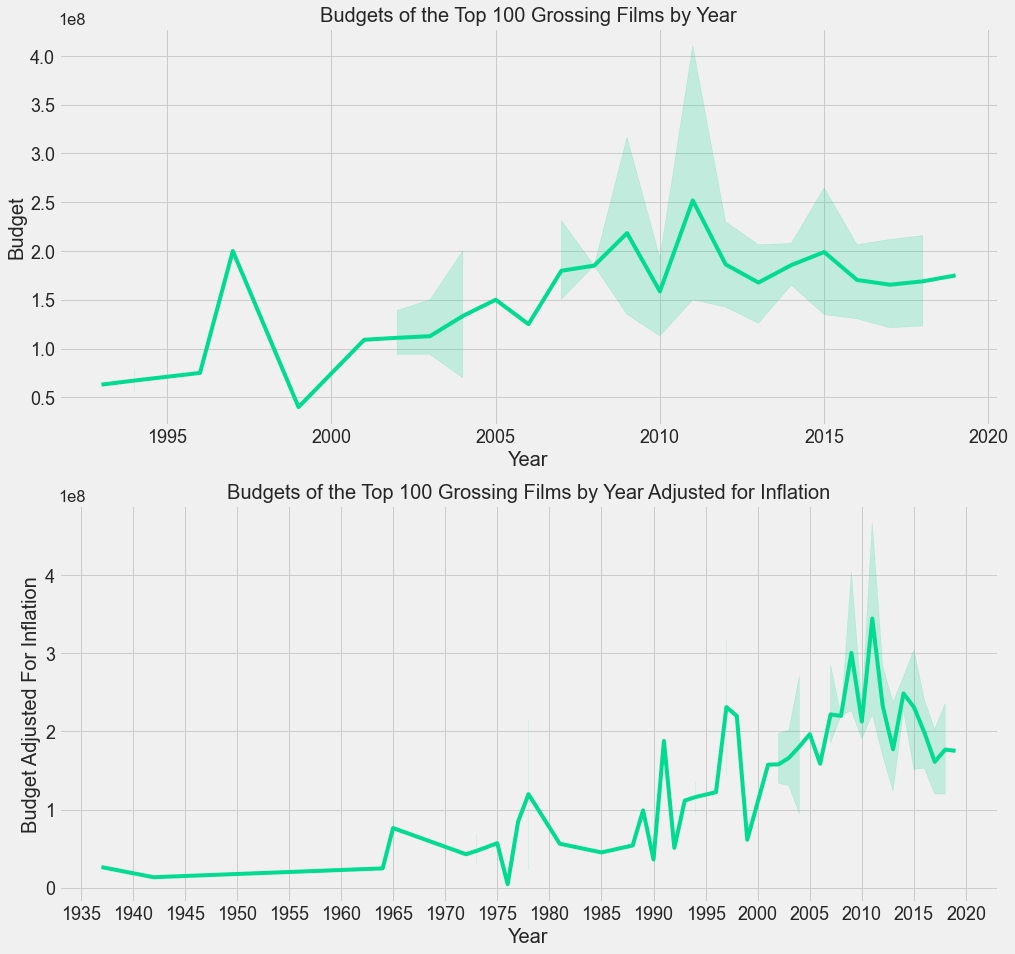

In [29]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ax=ax1)
sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films, ax=ax2)
# adjusting xticks
ax1.tick_params(labelsize=18) 
ax2.tick_params(labelsize=18)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())

# label for x-axis 
ax1.set_xlabel( "Year", size = 20 )
ax2.set_xlabel( "Year", size = 20 ) 
# label for y-axis 
ax1.set_ylabel( "Budget", size = 20 ) 
ax2.set_ylabel( "Budget Adjusted For Inflation", size = 20 ) 
# title for plot 
ax1.set_title( "Budgets of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Budgets of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
plt.show()

In [30]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

year  count
0  2017     11

In [31]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

year  count
0  2017      7

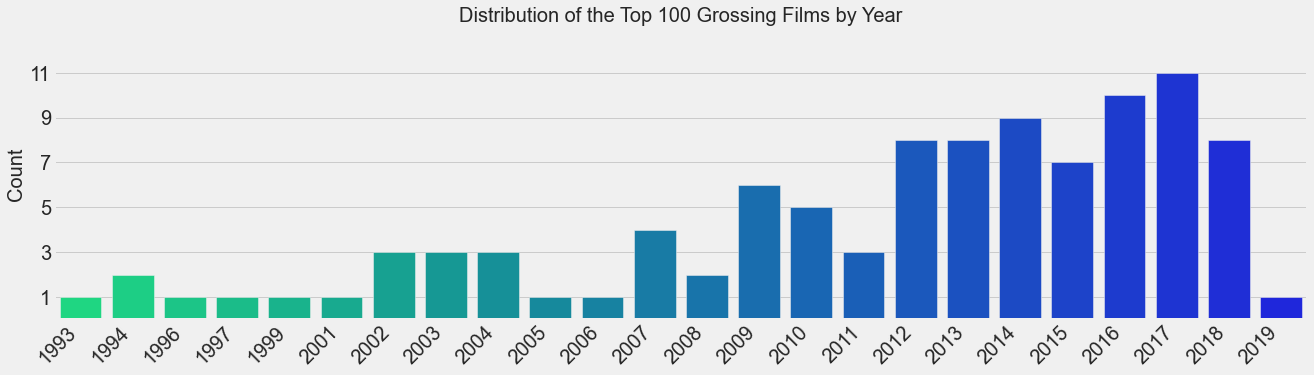

In [32]:
fig, ax= plt.subplots(figsize=(20,5))
ax = sns.barplot(x='year', y= 'count', data=t100_count_by_year, palette='winter_r')
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 13), yticks=[1, 3, 5, 7, 9, 11])
ax.tick_params(labelsize=20) 
# label for x-axis 
ax.set_xlabel("", size = 20)
# label for y-axis 
ax.set_ylabel("Count", size = 20) 
# title for plot 
ax.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 20 )
# render
plt.show()

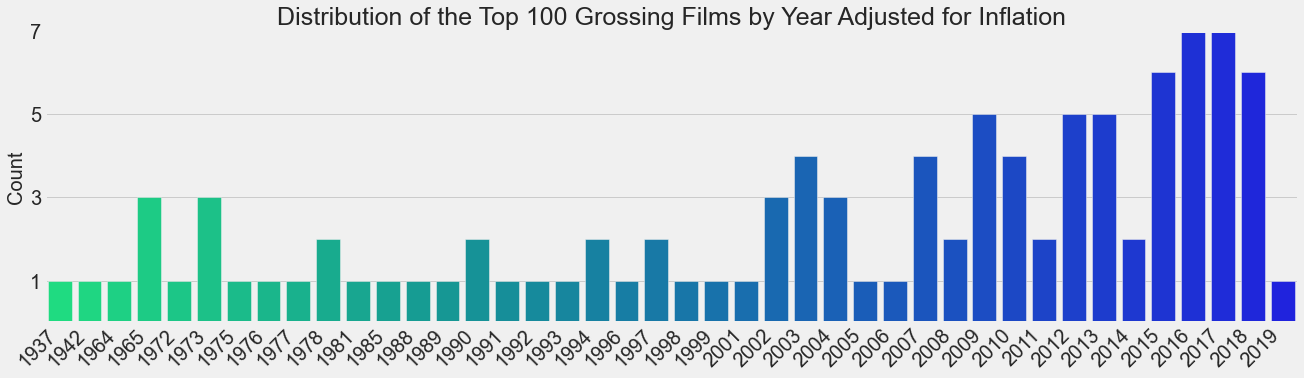

In [33]:
fig, ax= plt.subplots(figsize=(20,5))
ax = sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, palette='winter_r')
# adjusting ticks
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 7), yticks=[1, 3, 5, 7])
# label for x-axis 
ax.set_xlabel("", size = 20)
# label for y-axis 
ax.set_ylabel("Count", size = 20) 
# title for plot 
ax.set_title("Distribution of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 25)
# render
plt.show()

In [34]:
top20_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False).head(20)

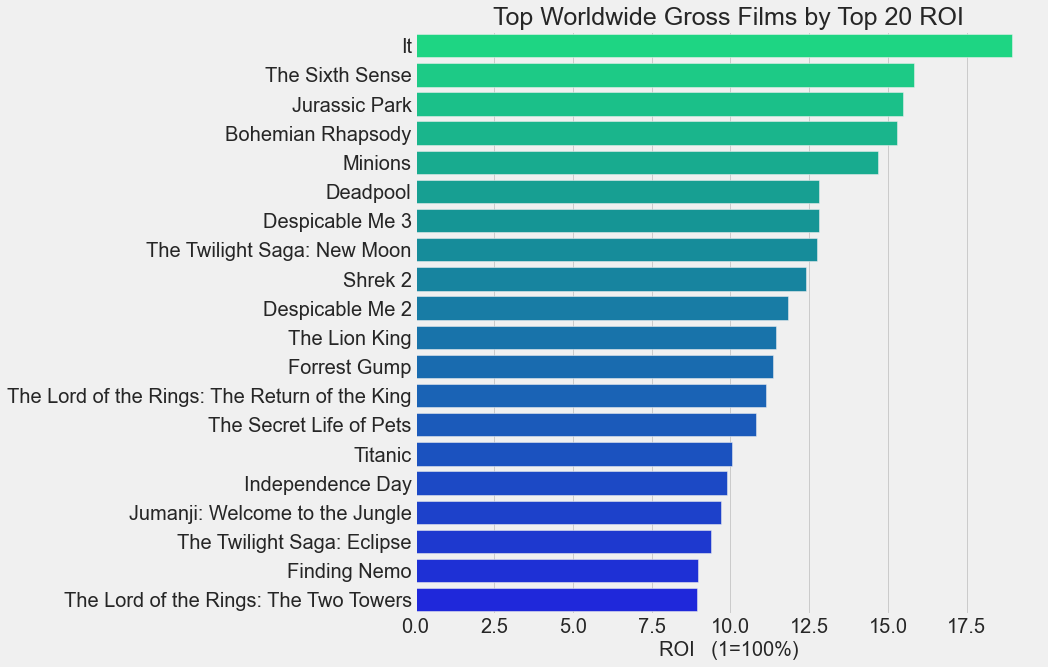

In [35]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data= top20_gross_by_roi, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("ROI   (1=100%)", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Worldwide Gross Films by Top 20 ROI', size = 25)
plt.show()

In [36]:
top20_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='adj_ww_roi', ascending=False).head(20)
# t100_adj_gross_by_roi.head(1)

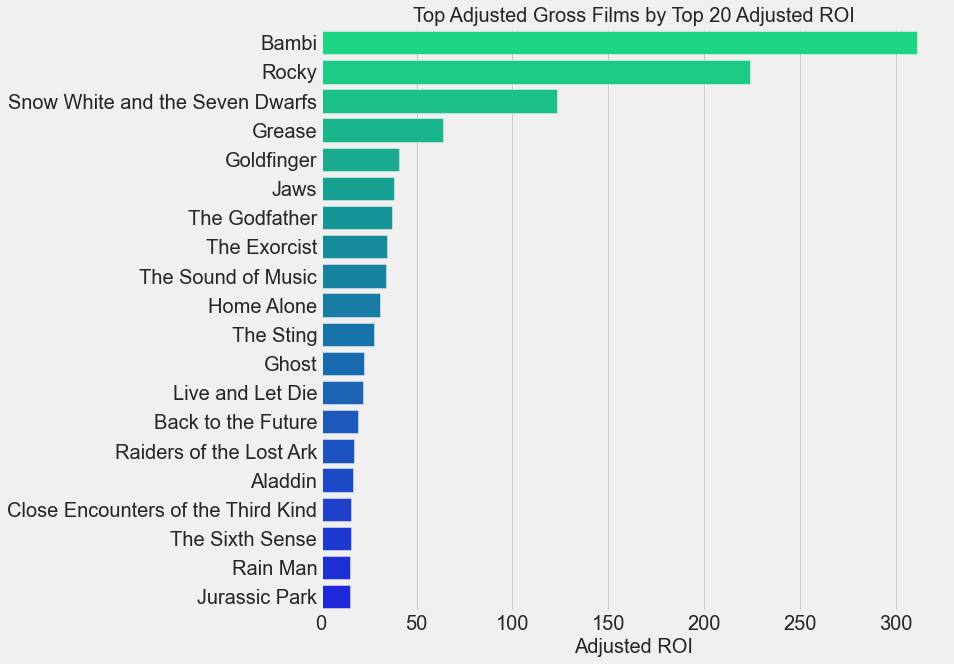

In [37]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_roi', y='title', data= top20_adj_gross_by_roi, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted ROI", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Adjusted Gross Films by Top 20 Adjusted ROI', size = 20)
plt.show()

In [38]:
title_net = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_titles = title_net.drop_duplicates(subset = ['title'])
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top20_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)

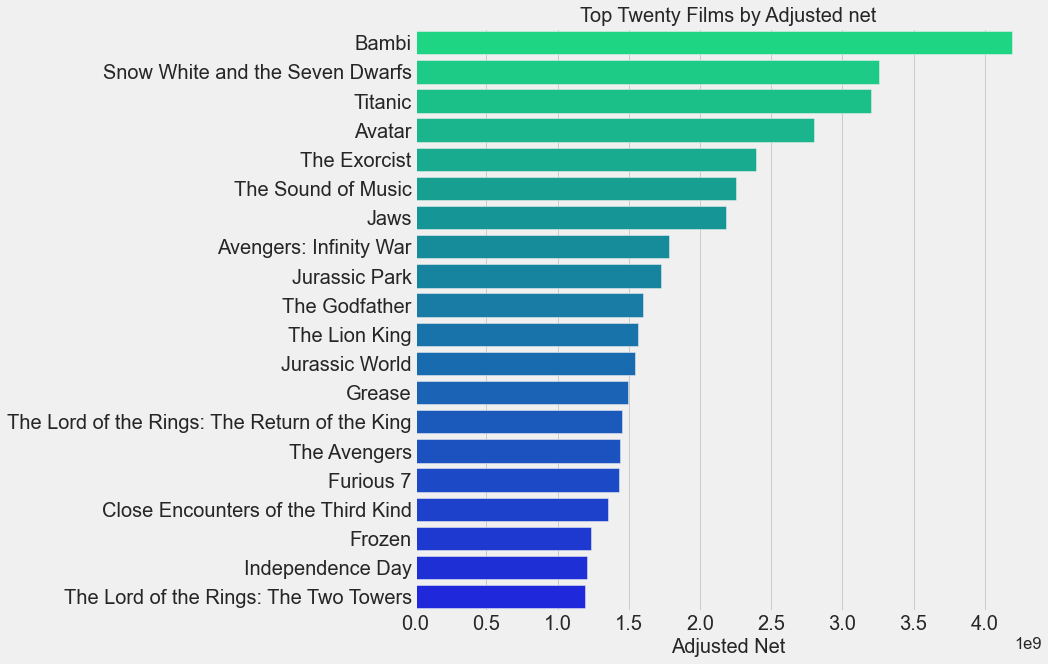

In [39]:
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_net', y='title', data= top20_net_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted Net", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Adjusted net', size = 20)
plt.show()

In [40]:
title_roi = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_titles = title_roi.drop_duplicates(subset = ['title'])
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top100_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(100)
top100_roi_films.head(1)

title  adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  \
2785  Mad Max  620526.699029  3.094877e+08  3.088672e+08      497.75   

                                                 genres  year  month  
2785  Action & Adventure, Cult Movies, Science Ficti...  1980      3

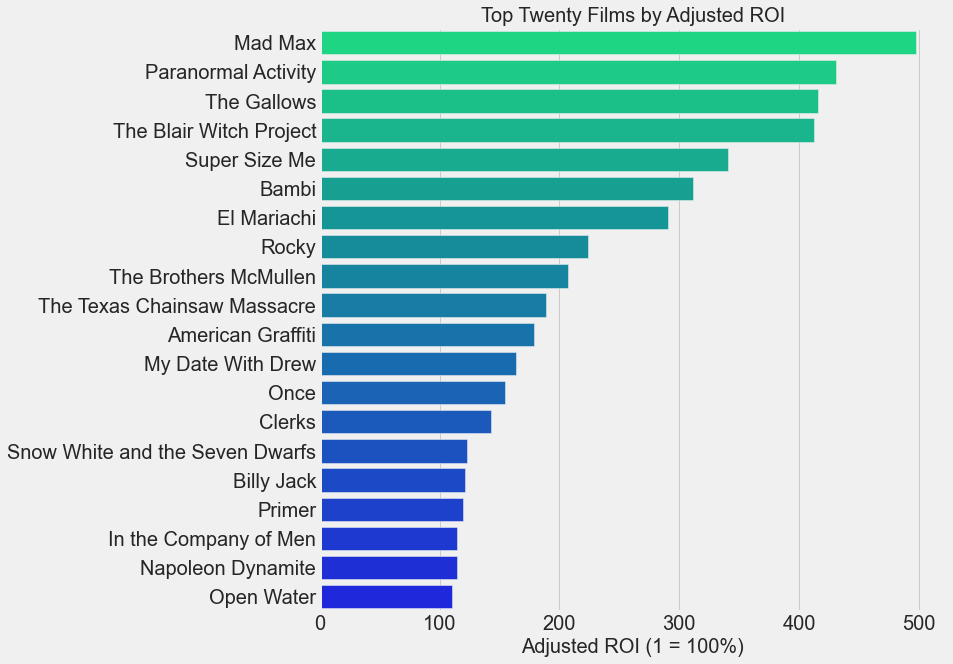

In [41]:
# plotting top 20 films by adjusted ROI
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_roi', y='title', data= top20_roi_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted ROI (1 = 100%)", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Adjusted ROI', size = 20)
plt.show()

## Top Talent Preliminary Work

In [42]:
# creating talent dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
dfi = pd.DataFrame(fetcha(q))
dfi.columns = [i[0] for i in cur.description]
dfi.head(1)     

idx     nconst       primary_name  birth_year  death_year  \
0    0  nm0061671  Mary Ellen Bauder         NaN         NaN   

                          primary_profession  \
0  miscellaneous,production_manager,producer   

                          known_for_titles     idx     tconst  ordering  ...  \
0  tt0837562,tt2398241,tt0844471,tt0118553  466550  tt2398241         9  ...   

  start_year runtime_minutes                      genres  idx id release_date  \
0       2017            90.0  Adventure,Animation,Comedy  904  5  Apr 7, 2017   

                      movie  production_budget domestic_gross  worldwide_gross  
0  Smurfs: The Lost Village        $60,000,000    $45,020,282     $197,578,586  

[1 rows x 26 columns]

In [43]:
# checking columns
dfi.columns

Index(['idx', 'nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles', 'idx', 'tconst', 'ordering',
       'category', 'job', 'characters', 'idx', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes', 'genres', 'idx',
       'id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [44]:
# checking dtypes
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [45]:
# dropping extraneous columns
dfi = dfi.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
dfi = dfi.rename(columns = {'movie':'title', 'release_date':'date'})
dfi.head(1)

nconst       primary_name     tconst  category  \
0  nm0061671  Mary Ellen Bauder  tt2398241  producer   

                       genres         date                     title  \
0  Adventure,Animation,Comedy  Apr 7, 2017  Smurfs: The Lost Village   

  production_budget domestic_gross worldwide_gross  
0       $60,000,000    $45,020,282    $197,578,586

In [46]:
# checking numbers of NaNs
dfi.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [47]:
#cleaning numerical strings and converting to floats
dfi['worldwide_gross'] = dfi['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['domestic_gross'] = dfi['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['production_budget'] = dfi['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [48]:
# change date string to datetime object 
dfi.date = pd.to_datetime(dfi.date)
dfi['year'] = dfi['date'].apply(lambda x: x.year)
dfi['month'] = dfi['date'].apply(lambda x: x.month)

In [49]:
# creating intl gross column
dfi['international_gross'] = dfi['worldwide_gross'].sub(dfi['domestic_gross'])

In [50]:
# defining function to adjust for inflation because the year
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [51]:
#adding adjusted budget and gross profit columns
dfi['adj_prod_budg'] = dfi.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
dfi['adj_dom_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
dfi['adj_ww_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
dfi['adj_i_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

In [52]:
#adding net profit columns
dfi['adj_dom_net'] = dfi['adj_dom_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_ww_net'] = dfi['adj_ww_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_i_net'] = dfi['adj_i_gross'].sub(dfi['adj_prod_budg'])

In [53]:
#adding return on investment columns and checking results
dfi['adj_dom_roi'] = dfi['adj_dom_net'].divide(dfi['adj_prod_budg'])
dfi['adj_ww_roi'] = dfi['adj_ww_net'].divide(dfi['adj_prod_budg'])
dfi['adj_i_roi'] = dfi['adj_i_net'].divide(dfi['adj_prod_budg'])
dfi.head(1)

nconst       primary_name     tconst  category  \
0  nm0061671  Mary Ellen Bauder  tt2398241  producer   

                       genres       date                     title  \
0  Adventure,Animation,Comedy 2017-04-07  Smurfs: The Lost Village   

   production_budget  domestic_gross  worldwide_gross  ...  adj_prod_budg  \
0         60000000.0      45020282.0      197578586.0  ...   6.257923e+07   

   adj_dom_gross  adj_ww_gross   adj_i_gross   adj_dom_net    adj_ww_net  \
0   4.695557e+07  2.060719e+08  1.591163e+08 -1.562365e+07  1.434927e+08   

      adj_i_net  adj_dom_roi  adj_ww_roi  adj_i_roi  
0  9.653712e+07    -0.249662    2.292976   1.542638  

[1 rows x 23 columns]

In [54]:
# creating imdb top adj goss list dataframes
title_adj_gross_i = dfi[['title', 'adj_ww_gross', 'date']]
unique_titles = title_adj_gross_i.drop_duplicates(subset = ['title'])
top20_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)
top100_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films_i.head(1)

title  adj_ww_gross       date
6985  Bambi  4.203440e+09 1942-08-13

In [55]:
# creating imdb top adj net list dataframes
title_net_i = dfi[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net' ,'date']]
unique_titles = title_net_i.drop_duplicates(subset = ['title'])
top20_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)
top100_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top20_adj_net_films_i.head(1)

title  adj_prod_budg  adj_ww_gross    adj_ww_net       date
6985  Bambi   1.345728e+07  4.203440e+09  4.189983e+09 1942-08-13

In [56]:
# creating imdb top adj roi list dataframes
title_roi_i = dfi[['title','adj_prod_budg',  'adj_ww_net', 'adj_ww_roi', 'date']]
unique_titles = title_roi_i.drop_duplicates(subset = ['title'])
top20_roi_films_i = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top100_roi_films_i = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(100)
top20_roi_films_i.head(1)

title  adj_prod_budg    adj_ww_net  adj_ww_roi       date
1230  The Gallows  107864.414789  4.482465e+07   415.56474 2015-07-10

##  Top Creative Talent

In [57]:
#  getting job titles
dfi.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

## Top 20 Actors By Adjusted Gross

In [58]:
#  dropping problematic titles
dfi = dfi[dfi.title != 'Titanic']
dfi = dfi[dfi.title != 'Cinderella']
dfi = dfi[dfi.title != 'Snow White and the Seven Dwarfs']
dfi = dfi[dfi.title != 'Beauty and the Beast']
dfi = dfi[dfi.title != 'Bambi']
dfi = dfi[dfi.title != 'Avatar']
dfi = dfi[dfi.title != 'Pinocchio']
dfi = dfi[dfi.title != 'Ben-Hur']

In [59]:
dfi.columns

Index(['nconst', 'primary_name', 'tconst', 'category', 'genres', 'date',
       'title', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'adj_prod_budg',
       'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross', 'adj_dom_net',
       'adj_ww_net', 'adj_i_net', 'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [60]:
# changings NaNs to strings
dfi['genres'] = dfi.genres.fillna('NaN')

In [61]:
# creating actor dataframe
actor_df = dfi[dfi['category'].str.contains('actor')]

In [62]:
# creating preliminary top 100 actors list
top100_grossing_actors = actor_df.groupby(['primary_name'])\
                                          .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_actors = pd.DataFrame(top100_grossing_actors)
top100_actors.head(1)

adj_ww_gross
primary_name                   
Robert Downey Jr.  1.049882e+10

In [63]:
# resetting index
reset_idx = top100_actors.reset_index()

In [64]:
# getting name list
actor_list = list(reset_idx.primary_name)

In [65]:
# running imdb actor list against rt movie list to work-around problematic titles.
gross = []
for name in actor_list:
    value = dfr[dfr['actors'].str.contains(name)].adj_ww_gross.sum()
    gross.append(value)
gross[:1]

[11347372028.952734]

In [66]:
#  creating new adj gross dataframe
dict = {'primary_name': actor_list, 'adj_ww_gross': gross}
gross_df = pd.DataFrame(dict, index=actor_list)
top50_adj_gross_actors = gross_df.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_actors.head(1)

primary_name  adj_ww_gross
Samuel L. Jackson  Samuel L. Jackson  1.942438e+10

In [67]:
# getting movie count
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)
count_m.head(1)

title
primary_name       
50 Cent           2

In [68]:
# joining dfs
joined_m = top50_adj_gross_actors.join(count_m)
joined_m.head(1)

primary_name  adj_ww_gross  title
Samuel L. Jackson  Samuel L. Jackson  1.942438e+10     12

In [69]:
# adding mean gross column
joined_m['mean_gross'] = joined_m.adj_ww_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [70]:
# sorting top 20 cumulative gross and mean gross films
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title', ascending=False).head(20)

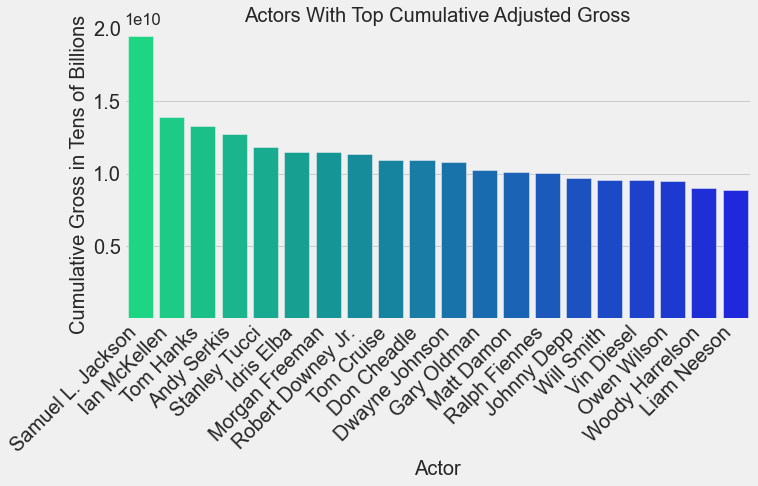

In [71]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 1*10**10), yticks=[.5*10**10, 1.0*10**10, 1.5*10**10, 2.0*10**10])
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("Actor", fontsize=20 )
ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20 )
ax.set_title("Actors With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

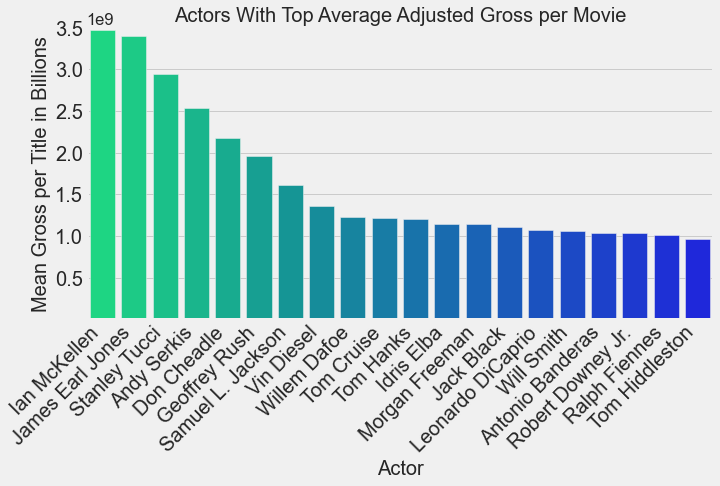

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9, 3.0*10**9, 3.5*10**9])
ax.set_xlabel("Actor", fontsize=20 ) 
ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actors With Top Average Adjusted Gross per Movie", fontsize=20) 
plt.show() 

## Top 20 Actresses By Adjusted Gross

In [73]:
# creating actress df
actress_df = dfi[dfi['category'].str.contains('actress')]

In [74]:
# initial top 100
top100_grossing_actresses = actress_df.groupby(['primary_name'])\
                                               .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_actresses = pd.DataFrame(top100_grossing_actresses)
top100_actresses.head(1)

adj_ww_gross
primary_name                   
Jennifer Lawrence  5.561662e+09

In [75]:
# resetting index
reset_idx_f = top100_actresses.reset_index()

In [76]:
# getting name list and adding kate winslet
actress_list = list(reset_idx_f.primary_name)[:99]
actress_list.append('Kate Winslet')

In [77]:
# running imdb actress list against rt movie list to work-around problematic titles.
gross_f = []
for name in actress_list:
    value = dfr[dfr['actors'].str.contains(name)].adj_ww_gross.sum()
    gross_f.append(value)
gross_f[:1]

[6420782167.258479]

In [78]:
#  creating new adj gross dataframe
dict = {'primary_name': actress_list, 'adj_ww_gross': gross_f}
gross_df_f = pd.DataFrame(dict, index=actress_list)
top50_adj_gross_actresses = gross_df_f.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_actresses.head(1)

primary_name  adj_ww_gross
Cate Blanchett  Cate Blanchett  1.652330e+10

In [79]:
# movie count
movie_count_f = actress_df.groupby(['primary_name']).title.count()

# movie_count_f = dfr[dfr['actors'].str.contains(name)].title.count()
count_f = pd.DataFrame(movie_count_f)
count_f.head(1)

title
primary_name       
AJ Michalka       2

In [80]:
# joining dfs
joined_f = top50_adj_gross_actresses.join(count_f)
joined_f.head(1)

primary_name  adj_ww_gross  title
Cate Blanchett  Cate Blanchett  1.652330e+10     10

In [81]:
# added mean gross column
joined_f['mean_gross'] = joined_f.adj_ww_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [82]:
# sorting top 20s
top20_cuml_gross_actresses = joined_f.sort_values\
                            (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values\
                            (by='Mean Gross per Title', ascending=False).head(20)

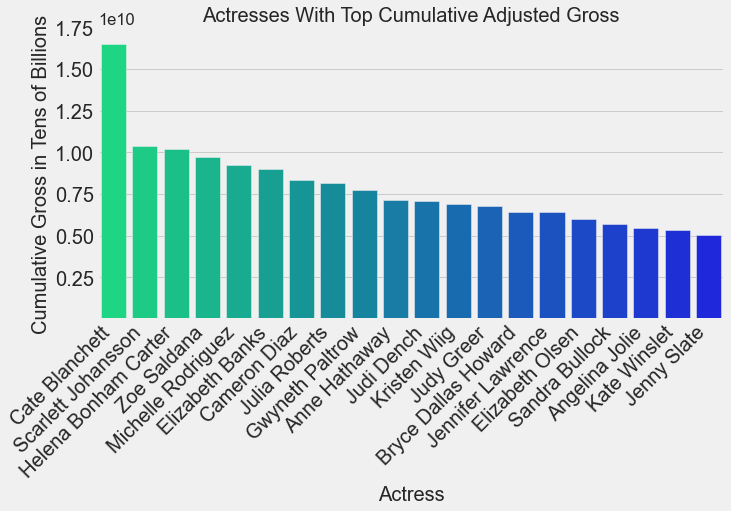

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Cumulative Gross', data=top20_cuml_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10, 1.5*10**10, 1.75*10**10])
ax.set_xlabel("Actress", fontsize=20 )
ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20 )
ax.set_title("Actresses With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

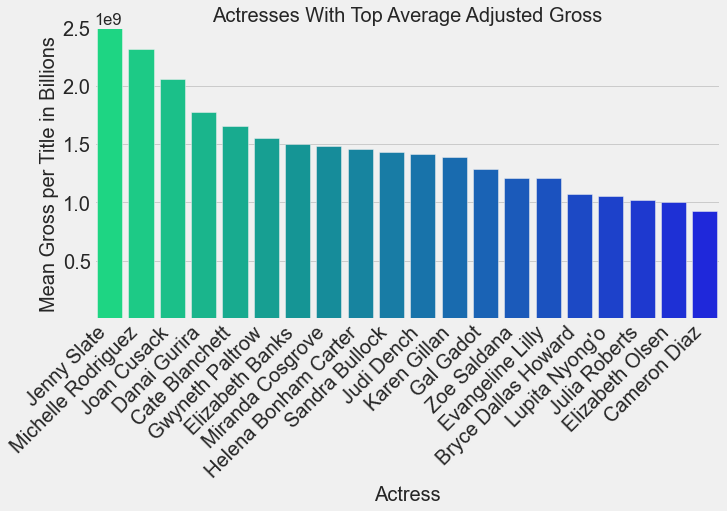

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Mean Gross per Title', data=top20_mean_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9])
ax.set_xlabel("Actress", fontsize=20 ) 
ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Average Adjusted Gross", fontsize=20) 
plt.show() 

## Top Directors by Adjusted Gross

In [85]:
# creating director df
director_df = dfi[dfi['category'].str.contains('director')]

In [86]:
# top 100 directors
top100_adj_gross_directors = director_df.groupby(['primary_name'])\
                                                 .adj_ww_gross.sum().sort_values(ascending=False).head(100)
top100_directors = pd.DataFrame(top100_adj_gross_directors)

In [87]:
# resting index
reset_idx_d = top100_directors.reset_index()

In [88]:
# getting name list adding james cameron
director_list = list(reset_idx_d.primary_name)[:99] 
director_list.append('James Cameron')

In [89]:
# running imdb director list against rt movie list to work-around problematic titles.
gross_d = []
for name in director_list:
    value = dfr[dfr['directors'].str.contains(name)].adj_ww_gross.sum()
    gross_d.append(value)
gross_d[:1]

[943414091.4183934]

In [90]:
#  creating new adj gross dataframe
dict = {'primary_name': director_list, 'adj_ww_gross': gross_d}
gross_df_d = pd.DataFrame(dict, index=director_list)
top50_adj_gross_directors = gross_df_d.sort_values(by='adj_ww_gross', ascending=False).head(50)

In [91]:
# movie count
movie_count_d = director_df.groupby(['primary_name']).title.count()
count_d = pd.DataFrame(movie_count_d)

In [92]:
# joining dfs
joined_d = top50_adj_gross_directors.join(count_d)

In [93]:
# adding mean gross column
joined_d['mean_gross'] = joined_d.adj_ww_gross/joined_d.title
joined_d = joined_d.reset_index()
joined_d = joined_d.rename(columns={'primary_name': 'Director',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [94]:
# adding values for james cameron
joined_d.loc[[2],'Number of Titles'] = dfr[dfr.directors.str.contains('James Cameron')].title.count()
joined_d.loc[[2], 'Mean Gross per Title'] = joined_d.loc[[2], 'Cumulative Gross']/joined_d.loc[[2],'Number of Titles']

In [95]:
# creating top 20 lists
top20_cuml_gross_directors = joined_d.sort_values\
                             (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_directors = joined_d.sort_values\
                             (by='Mean Gross per Title', ascending=False).head(20)
top20_cuml_gross_directors.head(1)

index          Director  Cumulative Gross  Number of Titles  \
0  Steven Spielberg  Steven Spielberg      1.517290e+10               8.0   

   Mean Gross per Title  
0          1.896612e+09

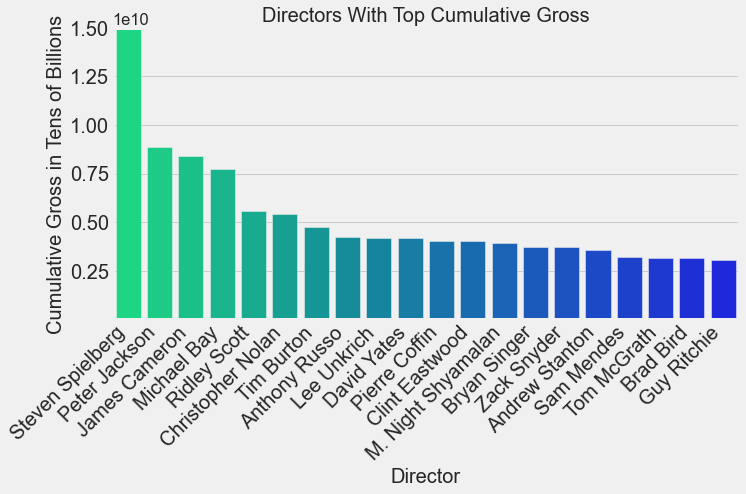

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Cumulative Gross', data=top20_cuml_gross_directors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10, 1.5*10**10])
ax.set_xlabel("Director", fontsize=20 )
ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20 )
ax.set_title("Directors With Top Cumulative Gross", fontsize=20)
plt.show()

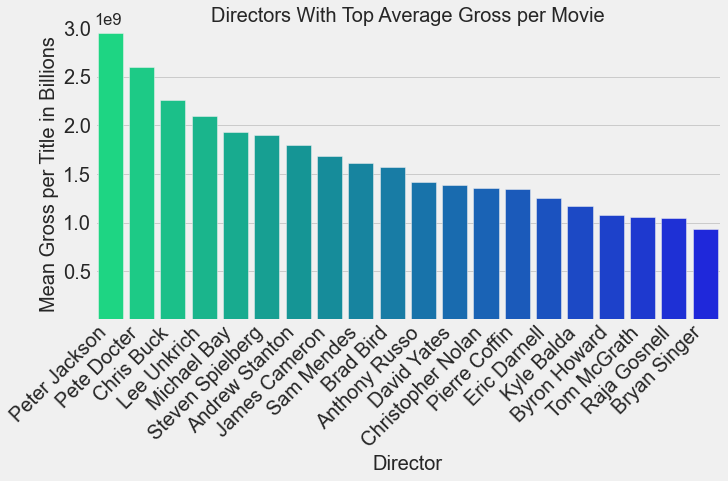

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Mean Gross per Title', data=top20_mean_gross_directors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9, 3.0*10**9])
ax.set_xlabel("Director", fontsize=20 ) 
ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Directors With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Top Writers by Gross

In [98]:
# creating writer df
writer_df = dfi[dfi['category'].str.contains('writer')]

In [99]:
# initial top 100
top100_adj_gross_writers = writer_df.groupby(['primary_name'])\
                                             .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_writers = pd.DataFrame(top100_adj_gross_writers)
top100_writers.head(1)

adj_ww_gross
primary_name              
Stan Lee      1.359341e+10

In [100]:
# resetting index
reset_idx_w = top100_writers.reset_index()

In [101]:
# getting name list
writer_list = list(reset_idx_w.primary_name)

In [102]:
# running imdb writer list against rt movie list to work-around problematic titles.
gross_w = []
for name in writer_list:
    value = dfr[dfr['authors'].str.contains(name)].adj_ww_gross.sum()
    gross_w.append(value)

In [103]:
#  creating new adj gross dataframe
dict = {'primary_name': writer_list, 'adj_ww_gross': gross_w}
gross_df_w = pd.DataFrame(dict, index=writer_list)
top50_adj_gross_writers = gross_df_w.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_writers.head(1)

primary_name  adj_ww_gross
Fran Walsh   Fran Walsh  8.936716e+09

In [104]:
# movie count
movie_count_w = writer_df.groupby(['primary_name']).title.count()
count_w = pd.DataFrame(movie_count_w)
count_w.head(1)

title
primary_name           
A. Jaye Williams      1

In [105]:
# joining dfs
joined_w = top50_adj_gross_writers.join(count_w)
joined_w.head(1)

primary_name  adj_ww_gross  title
Fran Walsh   Fran Walsh  8.936716e+09      4

In [106]:
# added mean gross column
joined_w['mean_gross'] = joined_w.adj_ww_gross/joined_w.title
joined_w = joined_w.reset_index()
joined_w = joined_w.rename(columns={'primary_name': 'Writer',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [107]:
# sorting top 20s
top20_cuml_gross_writers = joined_w.sort_values\
                        (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_writers = joined_w.sort_values\
                           (by='Mean Gross per Title', ascending=False).head(20)

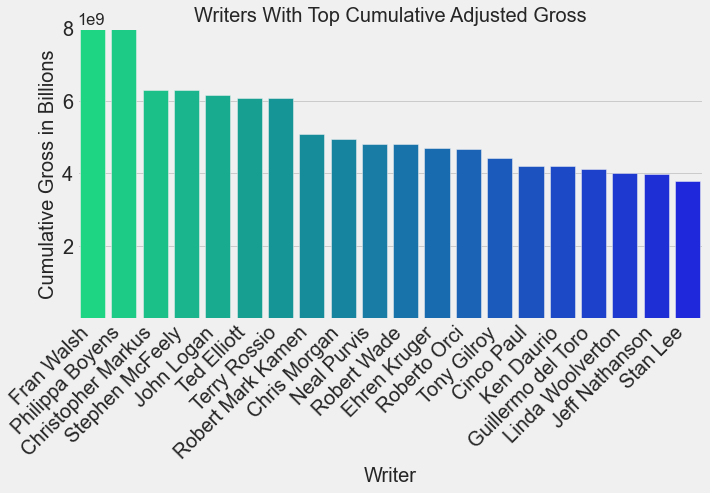

In [108]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Writer', y='Cumulative Gross', data=top20_cuml_gross_writers, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 10*10**8), yticks=[2*10**9, 4*10**9, 6*10**9, 8*10**9])
ax.set_xlabel( "Writer", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Writers With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

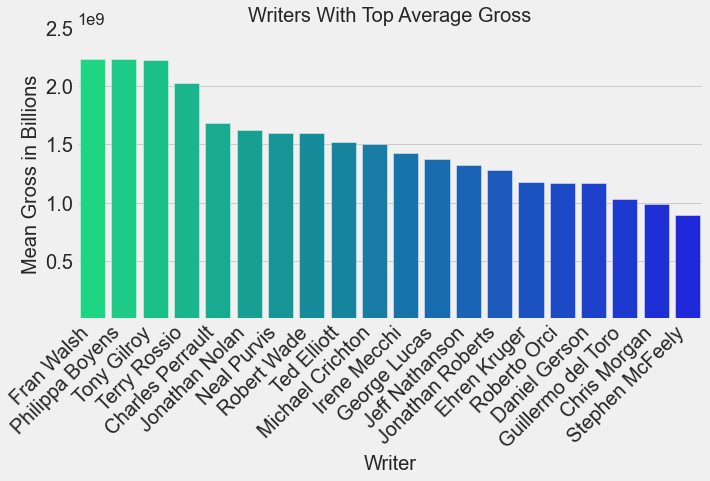

In [109]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Writer', y='Mean Gross per Title', data=top20_mean_gross_writers, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1*10**9, 1.5*10**9, 2*10**9, 2.5*10**9])
ax.set_xlabel("Writer", fontsize=20 )
ax.set_ylabel("Mean Gross in Billions" , fontsize=20 )
ax.set_title("Writers With Top Average Gross", fontsize=20)
plt.show()

## Top 20 Production Companies

In [110]:
top100_prod_companies = dfr.groupby(['production_company'])\
                                    .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_prod_companies = pd.DataFrame(top100_prod_companies)
top20_prod_companies = top100_prod_companies.head(20)
top20_prod_companies = top20_prod_companies.reset_index()

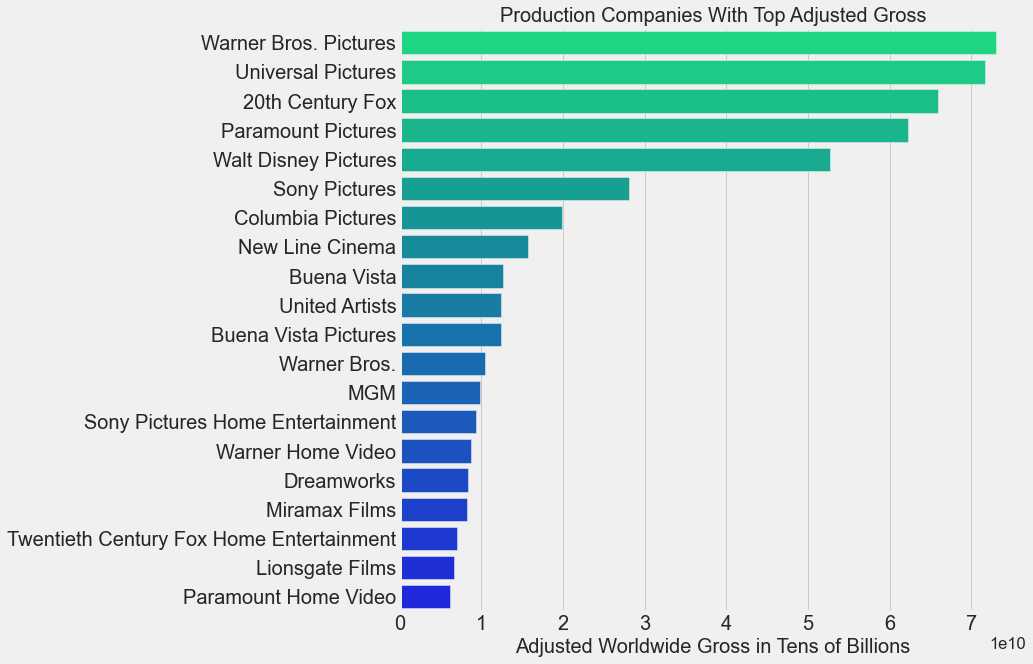

In [111]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='adj_ww_gross', y='production_company', data=top20_prod_companies, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted Worldwide Gross in Tens of Billions", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Production Companies With Top Adjusted Gross", fontsize=20)
plt.show()

## Top Producers

In [112]:
# creating imdb dataframes
title_dfi_p = dfi[['title', 'primary_name', 'worldwide_gross',\
                   'adj_ww_gross', 'date', 'category', 'genres']]
producer_df = title_dfi_p[title_dfi_p['category'] == 'producer']\
                                .sort_values(by='adj_ww_gross', ascending=False)

In [113]:
top100_prod = producer_df.groupby(['primary_name'])\
                                        .adj_ww_gross.sum().sort_values(ascending=False).head(100)
top100_producers = pd.DataFrame(top100_prod)
top100_producers.head(1)

adj_ww_gross
primary_name              
Kevin Feige   6.917241e+09

In [114]:
# resetting index
reset_idx_p = top100_producers.reset_index()

In [115]:
# getting name list
producer_list = list(reset_idx_p.primary_name)
len(producer_list)

100

In [116]:
# producer_df = 
producers_df = pd.DataFrame(reset_idx_p)
top20_producers = producers_df.head(20)

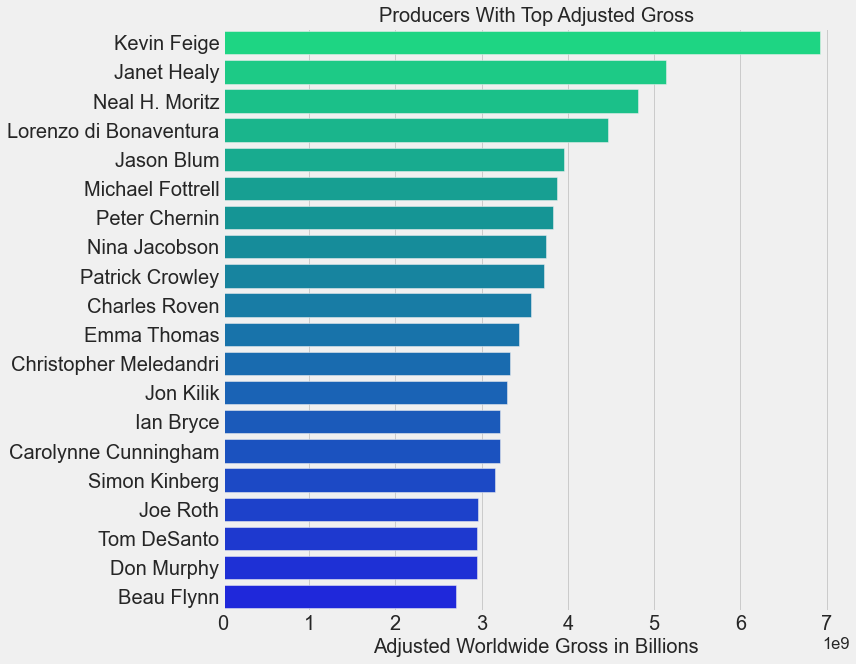

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='adj_ww_gross', y='primary_name', data=top20_producers, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted Worldwide Gross in Billions", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Producers With Top Adjusted Gross", fontsize=20)
plt.show()

## Genre Analysis

In [118]:
# creating genre list
split_list = []
for genre in dfr.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres[:1]

['science fiction & fantasy']

In [119]:
# creating function to count genres
def genre_count(DF, genre_list):
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append(count)
    return (genre_list, counts)

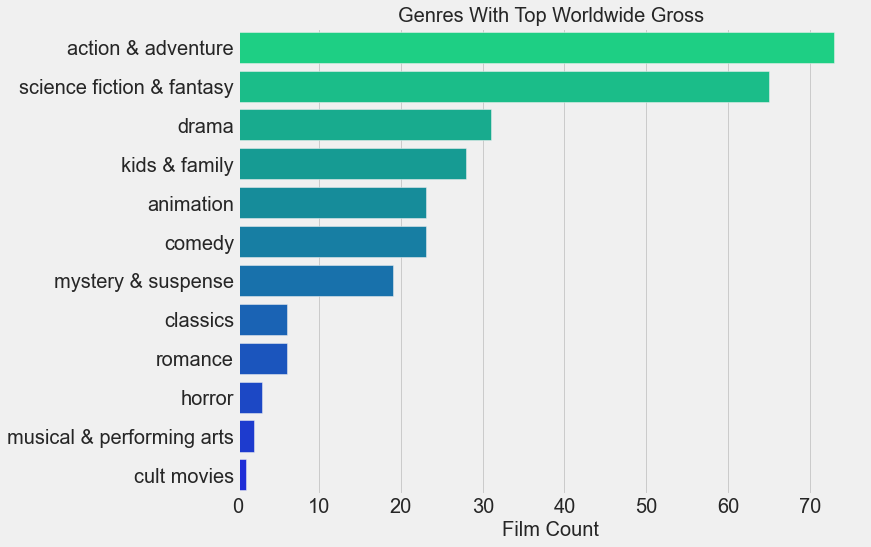

In [120]:
# top gross genres; there are overlaps because a film can have multiple genres
gross_genres = genre_count(top100_gross_films, genres)
top_g_genres = pd.DataFrame()
top_g_genres['Genre'] = gross_genres[0]
top_g_genres['Count'] = gross_genres[1]
top_g_genres = top_g_genres.sort_values(by='Count', ascending=False).head(12)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_g_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top Worldwide Gross", fontsize=20)
plt.show()

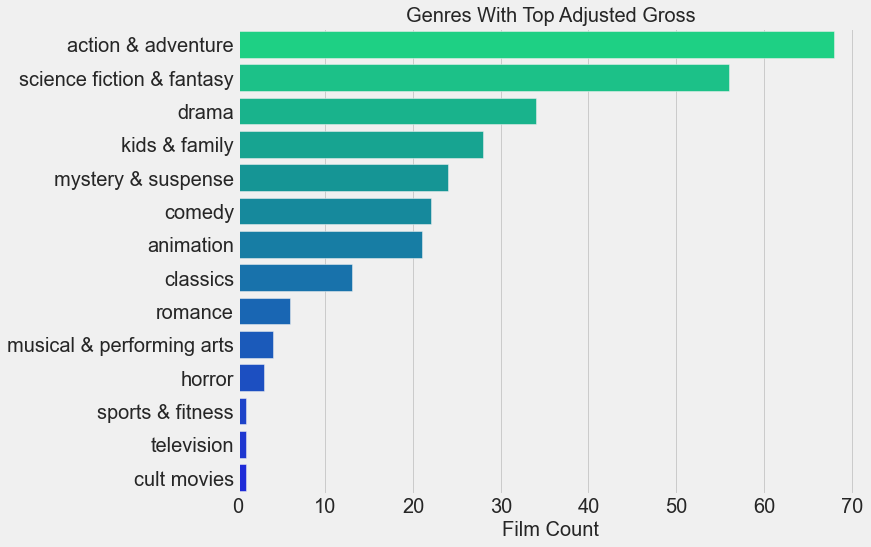

In [121]:
# top adjusted gross genres; there are overlaps because a film can have multiple genres
adj_genres = genre_count(top100_adj_gross_films, genres)
top_a_genres = pd.DataFrame()
top_a_genres['Genre'] = adj_genres[0]
top_a_genres['Count'] = adj_genres[1]
top_a_genres = top_a_genres.sort_values(by='Count', ascending=False).head(14)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_a_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top Adjusted Gross", fontsize=20)
plt.show()

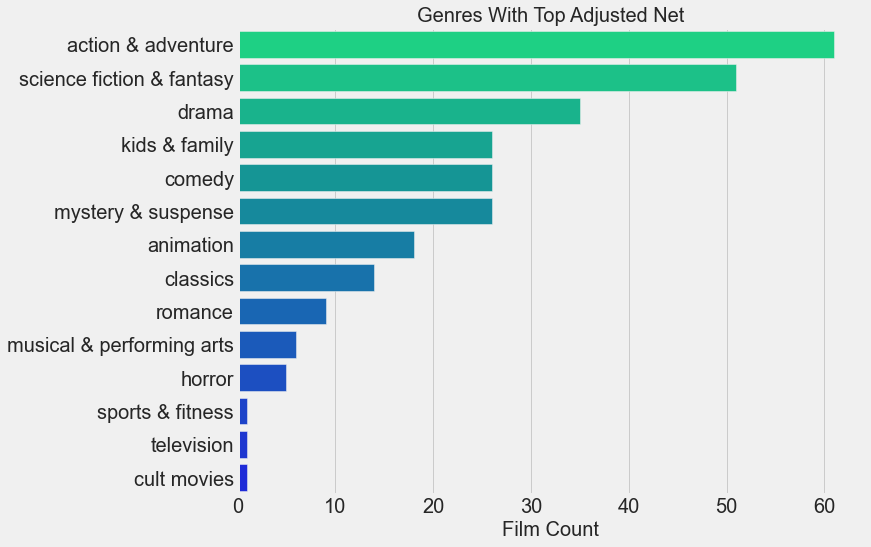

In [122]:
# top adjusted net genres; there are overlaps because a film can have multiple genres
net_genres = genre_count(top100_net_films, genres)
top_n_genres = pd.DataFrame()
top_n_genres['Genre'] = net_genres[0]
top_n_genres['Count'] = net_genres[1]
top_n_genres = top_n_genres.sort_values(by='Count', ascending=False).head(14)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_n_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top Adjusted Net", fontsize=20)
plt.show()

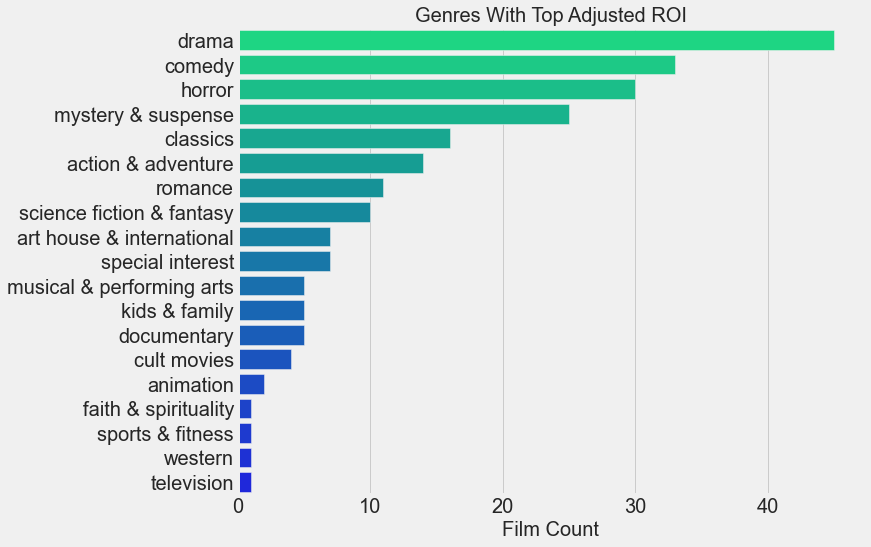

In [123]:
# top adjusted ROI genres; there are overlaps because a film can have multiple genres
roi_genres = genre_count(top100_roi_films, genres)
top_r_genres = pd.DataFrame()
top_r_genres['Genre'] = roi_genres[0]
top_r_genres['Count'] = roi_genres[1]
top_r_genres = top_r_genres.sort_values(by='Count', ascending=False).head(19)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_r_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top Adjusted ROI", fontsize=20)
plt.show()

## Talent Genres Prelim Work

In [124]:
# creating imdb genre list
split_list = []
for genre in dfi.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres_i = list(set(split_list))
genres_i[:1]

['sci-fi']

In [125]:
# creating function to count movies per genres 
def actor_genres(DF, genre_list):
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append((genre, count))
    return counts

In [126]:
# list sorting function
def sort_list(tup_list):   
    return(sorted(tup_list, key = lambda x: x[1], reverse=True))  

In [127]:
# counting each actor's films per genre
actor_counts = []
for actor in actor_list:
    actors_df = actor_df[actor_df['primary_name'] == actor]
    agenres = actor_genres(actors_df, genres_i)
    agenres = sort_list(agenres)
    actor_counts.append({actor: agenres})

## Actors Top Genres

In [128]:
# finding optimal genre by adjusted gross for each actor in top 100
optimal_genre = []
for actor in actor_list:
    collection = []
    for genre in genres_i:
        gross = actor_df[(actor_df['primary_name'] == actor)\
                         & (actor_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((actor, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
optimal_genre[:1]

[('Robert Downey Jr.', 'adventure', 10416618170.356846)]

In [129]:
# creating actor optimal genre dataframe
actor_genre = []
actor_gross = []
for i in range(100):
    actor_genre.append(optimal_genre[i][1])
    actor_gross.append(optimal_genre[i][2])
actor_genre_df = pd.DataFrame()
actor_genre_df['actor'] = actor_list
actor_genre_df['genre'] = actor_genre
actor_genre_df['adj_gross'] = actor_gross

In [130]:
# optimal genre for each actor
actor_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

actor      genre     adj_gross
0  Robert Downey Jr.  adventure  1.041662e+10

In [131]:
# genre counts for top 100 actors
actor_genre_df.genre.value_counts()

adventure    44
action       31
comedy       15
sci-fi        5
drama         3
fantasy       1
crime         1
Name: genre, dtype: int64

In [132]:
# genre counts for top 50
actor_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

adventure    26
action       16
comedy        6
crime         1
sci-fi        1
Name: genre, dtype: int64

## Actress Top Genres

In [133]:
# finding optimal genre by adjusted gross
optimal_genre = []
for actress in actress_list:
    collection = []
    for genre in genres_i:
        gross = actress_df[(actress_df['primary_name'] == actress)\
                         & (actress_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((actress, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [134]:
# creating optimal genre dataframe
actress_genre = []
actress_gross = []
for i in range(100):
    actress_genre.append(optimal_genre[i][1])
    actress_gross.append(optimal_genre[i][2])
actress_genre_df = pd.DataFrame()
actress_genre_df['actress'] = actress_list
actress_genre_df['genre'] = actress_genre
actress_genre_df['adj_gross'] = actress_gross

In [135]:
# optimal genre for each
actress_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

actress   genre     adj_gross
0  Jennifer Lawrence  sci-fi  4.685460e+09

In [136]:
# genre counts for top 100
actress_genre_df.genre.value_counts()

adventure    32
action       20
comedy       18
drama        12
fantasy       8
sci-fi        8
romance       1
family        1
Name: genre, dtype: int64

In [137]:
# genre counts for top 50
actress_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

adventure    15
action        9
comedy        9
sci-fi        6
drama         6
fantasy       5
Name: genre, dtype: int64

## Director Top Genres

In [138]:
# finding optimal genre by adjusted gross
optimal_genre = []
for director in director_list:
    collection = []
    for genre in genres_i:
        gross = director_df[(director_df['primary_name'] == director)\
                         & (director_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((director, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [139]:
# creating optimal genre dataframe
director_genre = []
director_gross = []
for i in range(100):
    director_genre.append(optimal_genre[i][1])
    director_gross.append(optimal_genre[i][2])
director_genre_df = pd.DataFrame()
director_genre_df['director'] = director_list
director_genre_df['genre'] = director_genre
director_genre_df['adj_gross'] = director_gross

In [140]:
# optimal genres for each
director_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

director   genre     adj_gross
0  Joe Russo  sci-fi  4.071155e+09

In [141]:
# genre counts for top 100
director_genre_df.genre.value_counts()

adventure      41
action         18
sci-fi         11
comedy          8
fantasy         6
drama           5
documentary     4
animation       2
horror          1
family          1
biography       1
nan             1
crime           1
Name: genre, dtype: int64

In [142]:
# genre counts for top 50
director_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

adventure    24
action        8
sci-fi        7
comedy        6
fantasy       4
drama         1
Name: genre, dtype: int64

## Writer Top Genres

In [143]:
# finding optimal genre by adjusted gross 
optimal_genre = []
for writer in writer_list:
    collection = []
    for genre in genres_i:
        gross = writer_df[(writer_df['primary_name'] == writer)\
                         & (writer_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((writer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [144]:
# creating optimal genre dataframe
writer_genre = []
writer_gross = []
for i in range(100):
    writer_genre.append(optimal_genre[i][1])
    writer_gross.append(optimal_genre[i][2])
writer_genre_df = pd.DataFrame()
writer_genre_df['writer'] = writer_list
writer_genre_df['genre'] = writer_genre
writer_genre_df['adj_gross'] = writer_gross

In [145]:
#optimal genres for each
writer_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

writer      genre     adj_gross
0  Stan Lee  adventure  1.359341e+10

In [146]:
# genre counts for top 100
writer_genre_df.genre.value_counts()

adventure    61
action       19
sci-fi        9
comedy        5
fantasy       4
thriller      1
crime         1
Name: genre, dtype: int64

In [147]:
# genre counts for top 50
writer_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

adventure    29
action       12
sci-fi        5
comedy        2
fantasy       1
crime         1
Name: genre, dtype: int64

## Producer Top Genres

In [148]:
# finding optimal genre by adjusted gross
optimal_genre = []
for producer in producer_list:
    collection = []
    for genre in genres_i:
        gross = producer_df[(producer_df['primary_name'] == producer)\
                         & (producer_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((producer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
len(optimal_genre)

100

In [149]:
# creating optimal genre dataframe
producer_genre = []
producer_gross = []
for i in range(100):
    producer_genre.append(optimal_genre[i][1])
    producer_gross.append(optimal_genre[i][2])
producer_genre_df = pd.DataFrame()
producer_genre_df['producer'] = producer_list
producer_genre_df['genre'] = producer_genre
producer_genre_df['adj_gross'] = producer_gross

In [150]:
# optimal gernres for each
producer_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

producer      genre     adj_gross
0  Kevin Feige  adventure  6.917241e+09

In [151]:
# genre count for top 100
producer_genre_df.genre.value_counts()

adventure    28
action       22
drama        19
comedy       11
fantasy       6
sci-fi        6
horror        4
animation     2
mystery       1
crime         1
Name: genre, dtype: int64

In [152]:
# genre count for top 50
producer_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

adventure    22
drama        10
action        8
sci-fi        4
comedy        3
fantasy       1
horror        1
crime         1
Name: genre, dtype: int64

# Genre Stats

## Big Five Genres

In [153]:
action_df = dfr[dfr['genres'].str.contains('action & adventure', case=False)]
unique_titles_a = action_df.drop_duplicates(subset = ['title'])
top100_action = unique_titles_a.sort_values(by='worldwide_gross', ascending=False).head(100)
action = top100_action[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [154]:
action.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   2011.500000       1.783150e+08     8.985821e+08       4.493798   
std       5.732241       6.455350e+07     3.525110e+08       2.481603   
min    1993.000000       5.800000e+07     5.610721e+08       1.186484   
25%    2008.000000       1.380000e+08     6.550139e+08       2.994261   
50%    2013.000000       1.725000e+08     8.017142e+08       3.749433   
75%    2016.000000       2.000000e+08     1.017610e+09       5.231247   
max    2019.000000       4.250000e+08     2.776345e+09      15.489089   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    2.025672e+08  1.040482e+09  8.379144e+08    4.493798  
std     7.023169e+07  4.585390e+08  4.313338e+08    2.481603  
min     6.178197e+07  5.851909e+08  3.712463e+08    1.186484  
25%     1.571595e+08  7.529433e+08  5.844180e+08    2.994261  
50%     1.897374e+08  9.104515e+08  7.071914e+08    3.749433  
75%     2.325532e+08  1.190419e+09  9.684087e+08    5.231247  
max     5.064591e+08  3.517408e+09  3.198832e+09   15.489089

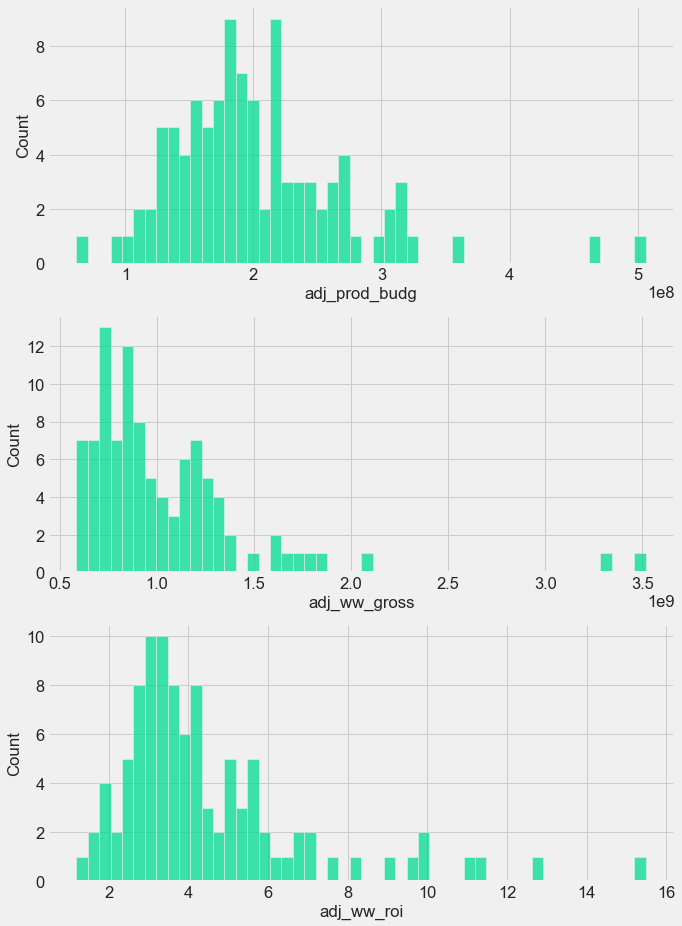

In [155]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(action.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(action.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(action.adj_ww_roi, bins=50, ax=ax3)
plt.show()

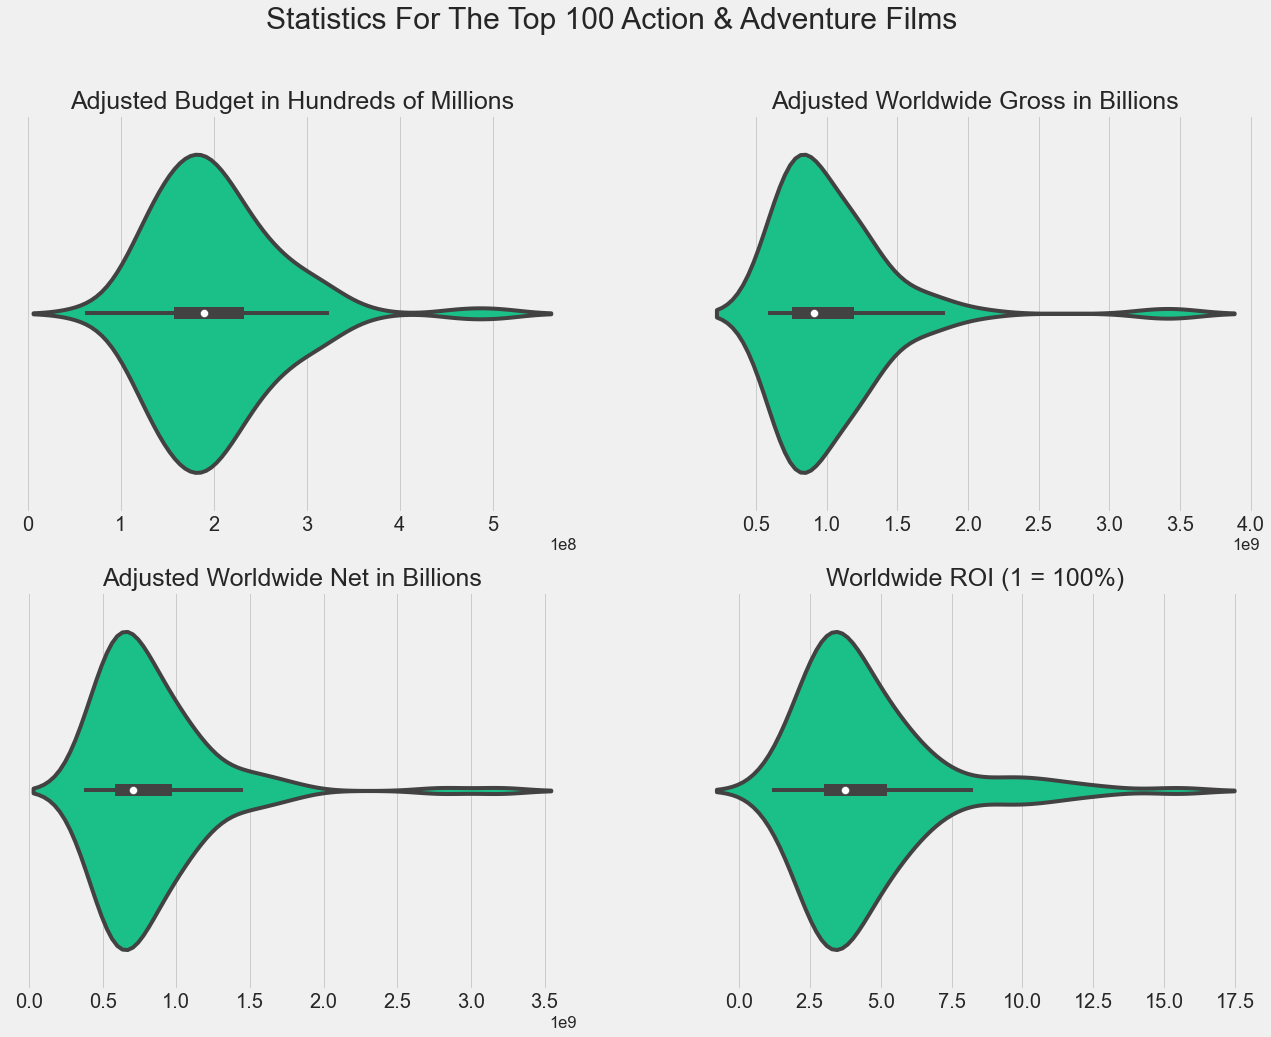

In [156]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=action)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=action)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=action)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=action)
fig.suptitle('Statistics For The Top 100 Action & Adventure Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
# plt.tight_layout()
plt.show()

In [157]:
scifi_df = dfr[(dfr['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles_s = scifi_df.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles_s.sort_values(by='adj_ww_net', ascending=False).head(100)
scifi = top100_scifi[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [158]:
scifi.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   2004.430000       1.413693e+08     7.718313e+08      10.460937   
std      16.633455       8.341692e+07     3.806996e+08      32.894196   
min    1937.000000       8.580000e+05     3.430548e+07       1.546673   
25%    2002.000000       8.775000e+07     5.798160e+08       3.262811   
50%    2010.000000       1.475000e+08     7.569612e+08       4.550539   
75%    2014.000000       1.962500e+08     9.348282e+08       7.086476   
max    2019.000000       4.250000e+08     2.776345e+09     311.354312   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.696413e+08  1.045376e+09  8.757352e+08   10.460937  
std     8.590455e+07  5.385395e+08  5.311848e+08   32.894196  
min     1.345728e+07  5.694961e+08  4.739878e+08    1.546673  
25%     1.122742e+08  7.543903e+08  6.012608e+08    3.262811  
50%     1.740402e+08  8.947751e+08  7.495649e+08    4.550539  
75%     2.168608e+08  1.169386e+09  9.660802e+08    7.086476  
max     5.064591e+08  4.203440e+09  4.189983e+09  311.354312

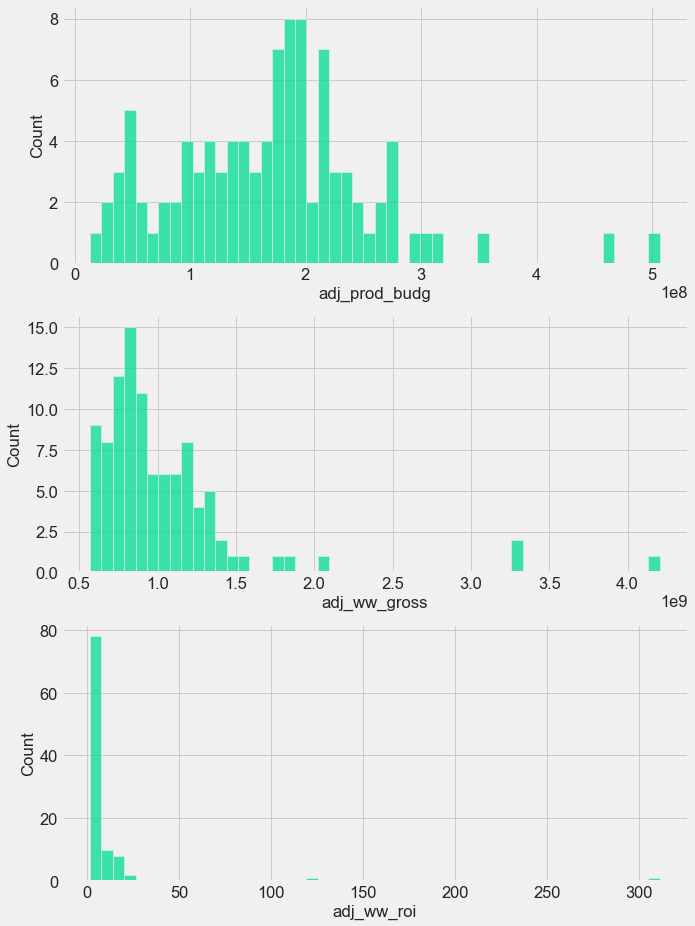

In [159]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(scifi.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(scifi.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(scifi.adj_ww_roi, bins=50, ax=ax3)
plt.show()

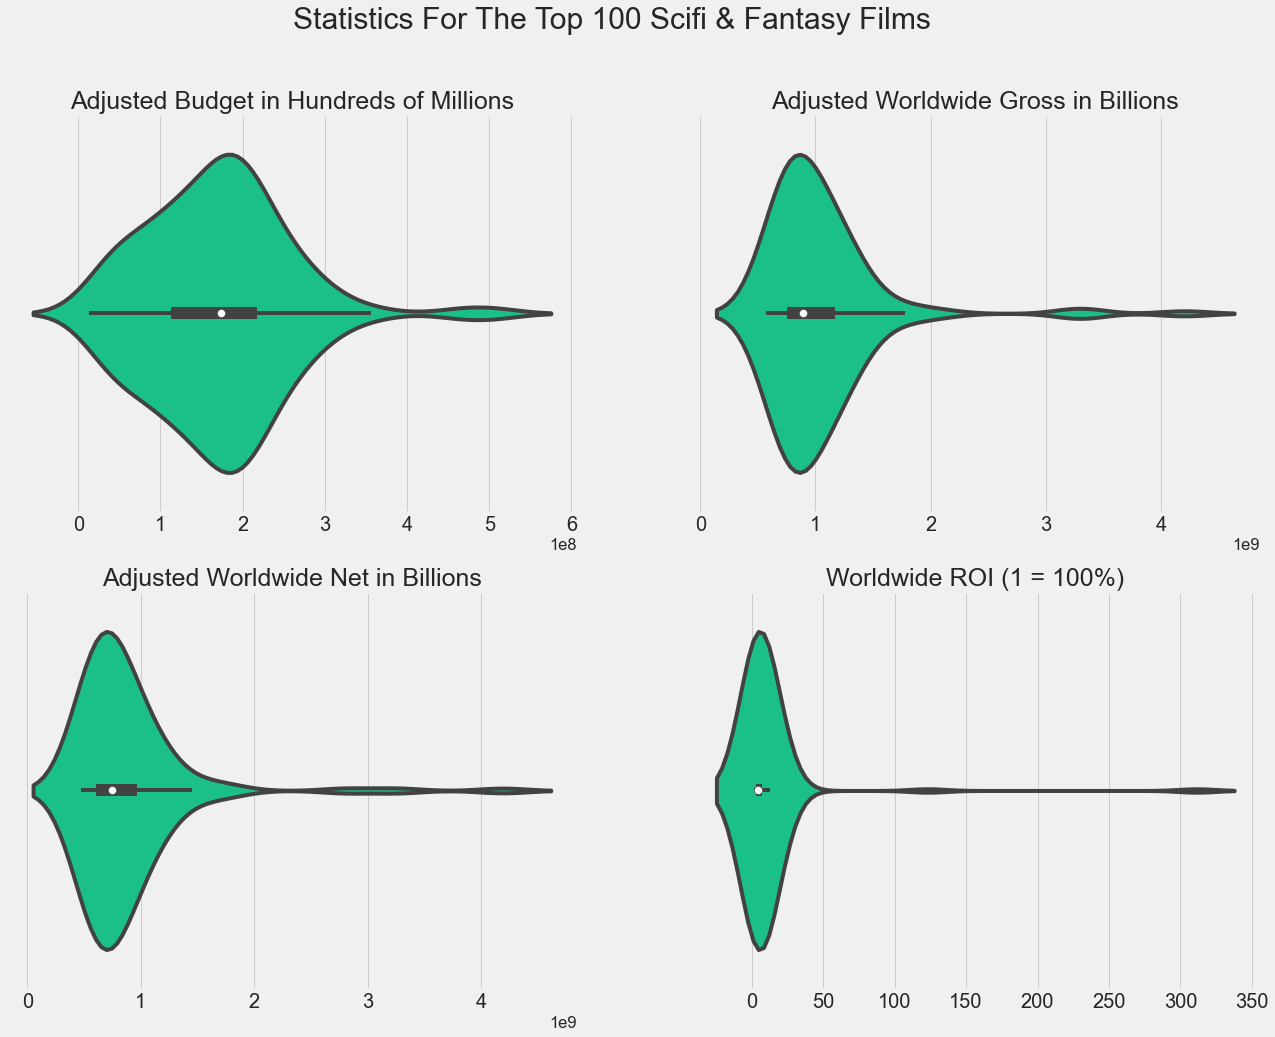

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=scifi)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=scifi)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=scifi)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=scifi)
fig.suptitle('Statistics For The Top 100 Scifi & Fantasy Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [161]:
drama_df = dfr[(dfr['genres'].str.contains('drama', case=False))]
unique_titles_d = drama_df.drop_duplicates(subset = ['title'])
top100_drama = unique_titles_d.sort_values(by='adj_ww_net', ascending=False).head(100)
drama = top100_drama[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [162]:
drama.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   1998.380000       8.799077e+07     5.538411e+08      14.585568   
std      16.898855       7.220352e+07     3.532062e+08      30.676928   
min    1956.000000       7.770000e+05     6.000000e+07       1.572574   
25%    1988.750000       1.910000e+07     3.167676e+08       4.019681   
50%    2001.500000       7.965000e+07     4.775737e+08       5.810391   
75%    2012.250000       1.500000e+08     7.599021e+08      13.108057   
max    2018.000000       2.750000e+08     2.208208e+09     224.000000   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.196164e+08  8.575911e+08  7.379747e+08   14.585568  
std     7.573288e+07  4.367183e+08  4.166558e+08   30.676928  
min     4.473998e+06  4.190149e+08  3.933203e+08    1.572574  
25%     5.550426e+07  5.936157e+08  4.819644e+08    4.019681  
50%     1.194103e+08  7.508345e+08  6.496895e+08    5.810391  
75%     1.743389e+08  9.690354e+08  8.245330e+08   13.108057  
max     3.185757e+08  3.517408e+09  3.198832e+09  224.000000

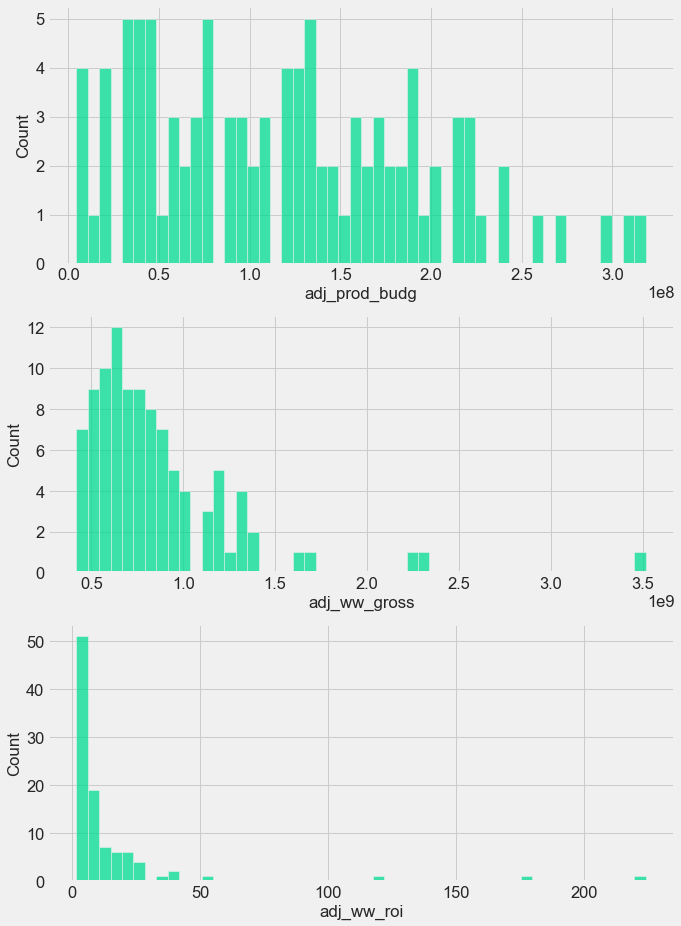

In [163]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(drama.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(drama.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(drama.adj_ww_roi, bins=50, ax=ax3)
plt.show()

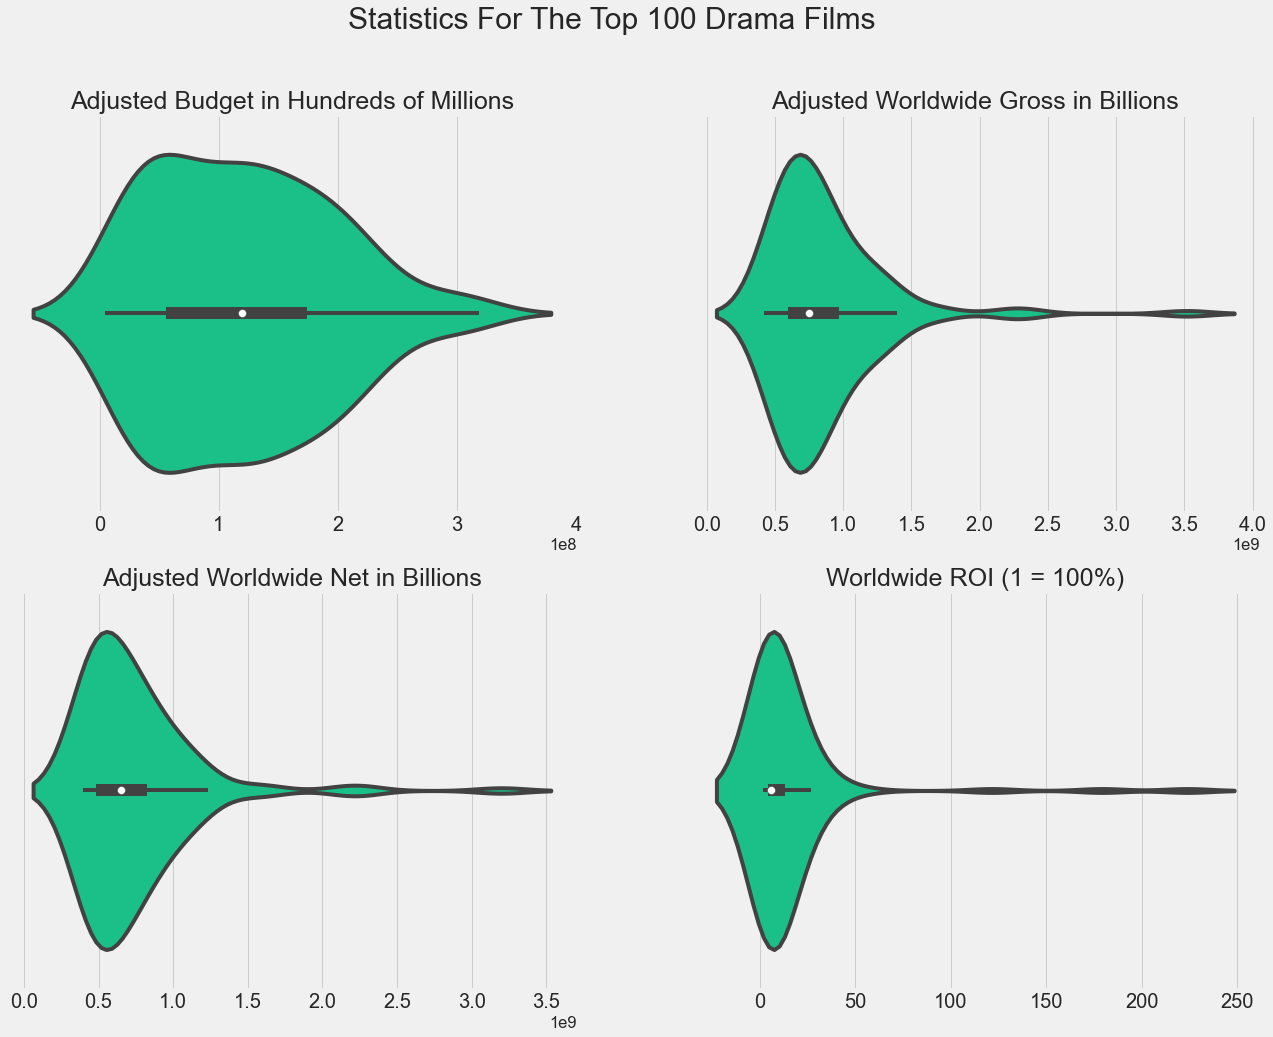

In [164]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=drama)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=drama)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=drama)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=drama)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [165]:
family_df = dfr[(dfr['genres'].str.contains('kids & family', case=False))]
unique_titles_f = family_df.drop_duplicates(subset = ['title'])
top100_family = unique_titles_f.sort_values(by='adj_ww_net', ascending=False).head(100)
family = top100_family[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [166]:
family.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   2001.980000       1.016162e+08     5.505325e+08      10.390570   
std      17.541282       6.004031e+07     2.847136e+08      33.024169   
min    1937.000000       8.580000e+05     3.430548e+07       1.255682   
25%    1998.000000       6.500000e+07     3.515180e+08       3.161268   
50%    2007.000000       9.300000e+07     5.111185e+08       4.209438   
75%    2012.250000       1.500000e+08     7.444216e+08       7.259011   
max    2019.000000       2.600000e+08     1.272470e+09     311.354312   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.279304e+08  8.047117e+08  6.767812e+08   10.390570  
std     6.192503e+07  5.357607e+08  5.429735e+08   33.024169  
min     1.345728e+07  3.277699e+08  2.878331e+08    1.255682  
25%     7.942076e+07  5.261783e+08  3.857583e+08    3.161268  
50%     1.270109e+08  6.638725e+08  5.300126e+08    4.209438  
75%     1.781326e+08  8.946093e+08  7.950104e+08    7.259011  
max     3.048337e+08  4.203440e+09  4.189983e+09  311.354312

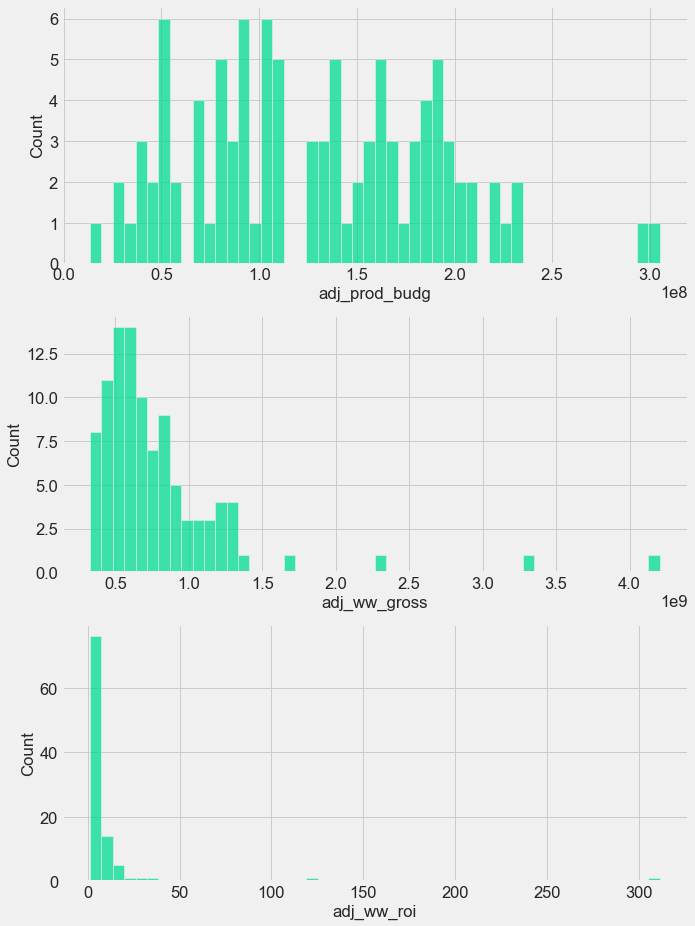

In [167]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(family.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(family.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(family.adj_ww_roi, bins=50, ax=ax3)
plt.show()

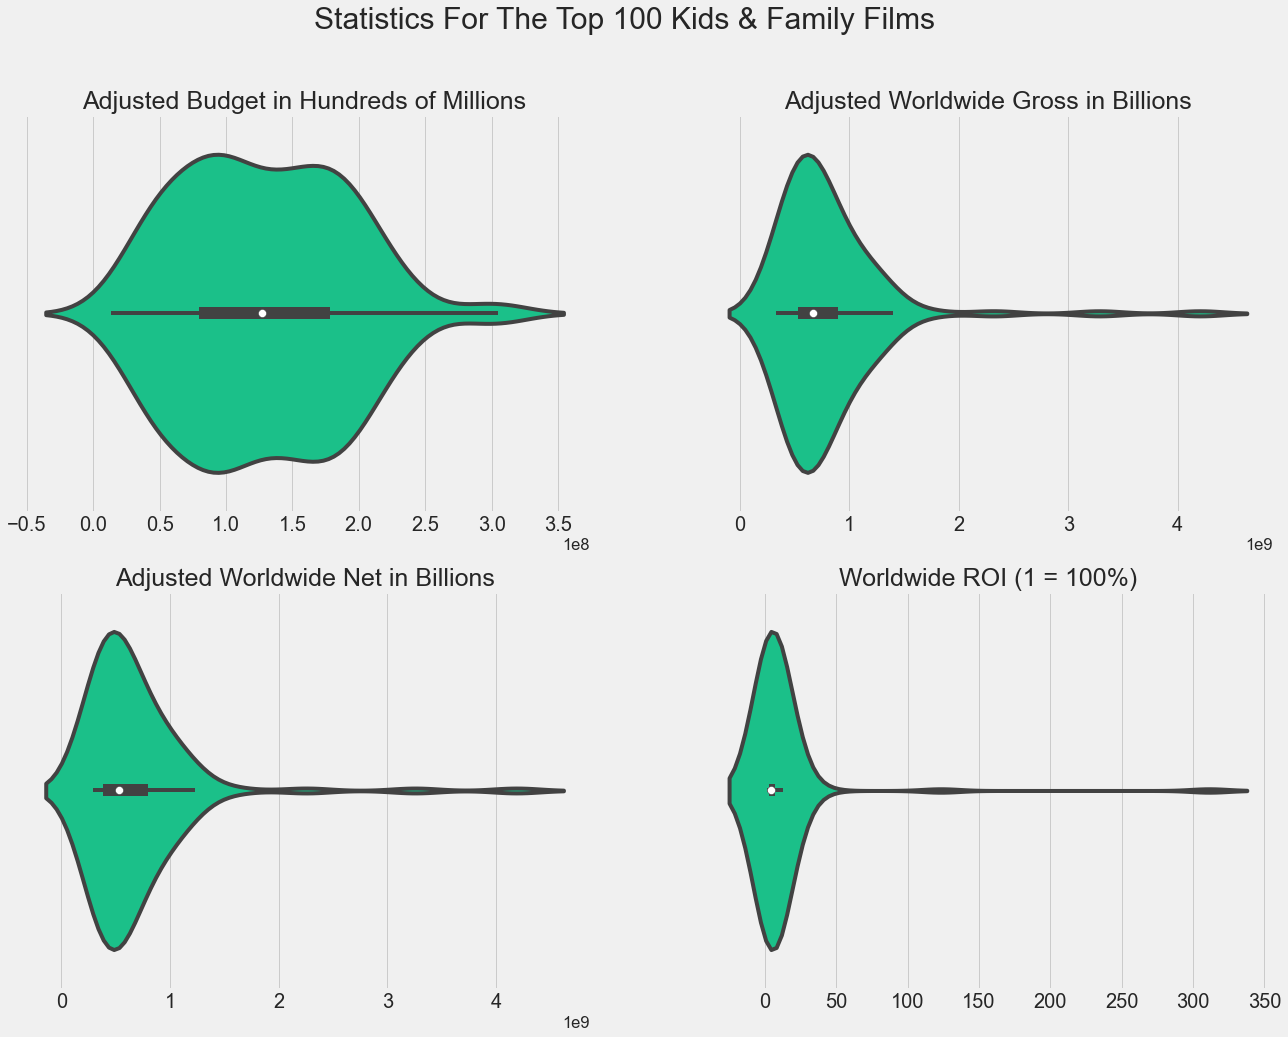

In [168]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=family)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=family)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=family)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=family)
fig.suptitle('Statistics For The Top 100 Kids & Family Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [169]:
mystery_df = dfr[(dfr['genres'].str.contains('mystery & suspense', case=False))]
unique_titles_m = mystery_df.drop_duplicates(subset = ['title'])
top100_mystery = unique_titles_m.sort_values(by='adj_ww_net', ascending=False).head(100)
mystery = top100_mystery[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [170]:
mystery.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.00000       1.000000e+02     1.000000e+02     100.000000   
mean   1998.16000       8.399603e+07     4.702527e+08       8.815051   
std      14.42341       7.249287e+07     3.753899e+08      10.409541   
min    1963.00000       1.000000e+06     5.956704e+07       1.572574   
25%    1990.00000       2.950000e+07     2.665057e+08       3.015911   
50%    2001.00000       7.285131e+07     3.609445e+08       4.747841   
75%    2009.00000       1.250000e+08     5.550299e+08       9.558434   
max    2018.00000       4.250000e+08     2.776345e+09      58.567035   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.176330e+08  7.335896e+08  6.159566e+08    8.815051  
std     7.914311e+07  4.391955e+08  4.035152e+08   10.409541  
min     5.214936e+06  2.909567e+08  2.845317e+08    1.572574  
25%     5.945324e+07  4.707996e+08  3.622374e+08    3.015911  
50%     1.082075e+08  5.938407e+08  4.751254e+08    4.747841  
75%     1.528633e+08  8.280635e+08  7.408709e+08    9.558434  
max     5.064591e+08  3.308483e+09  2.802024e+09   58.567035

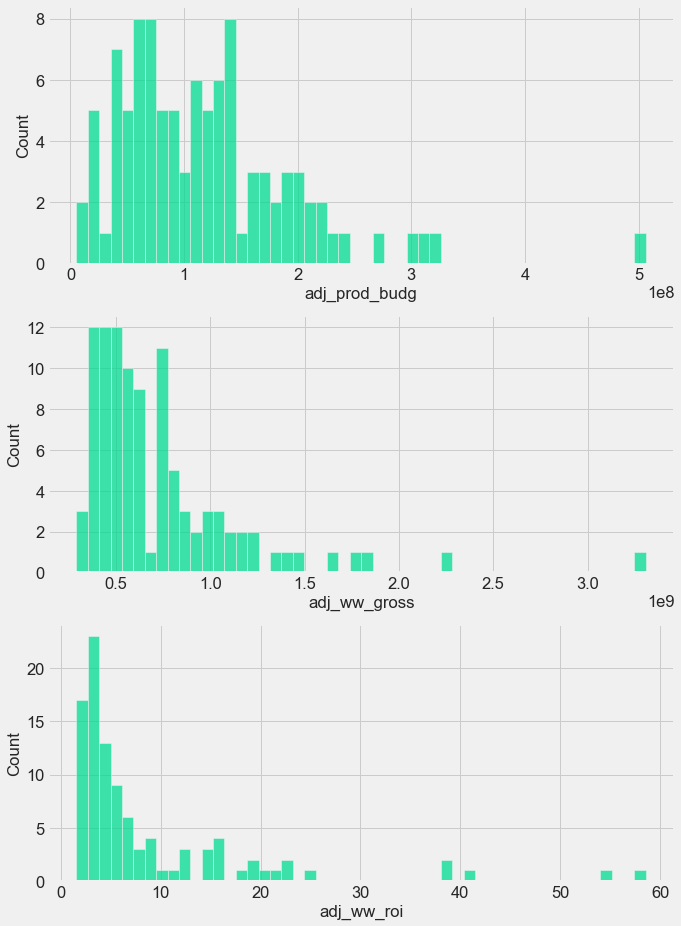

In [171]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(mystery.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(mystery.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(mystery.adj_ww_roi, bins=50, ax=ax3)
plt.show()

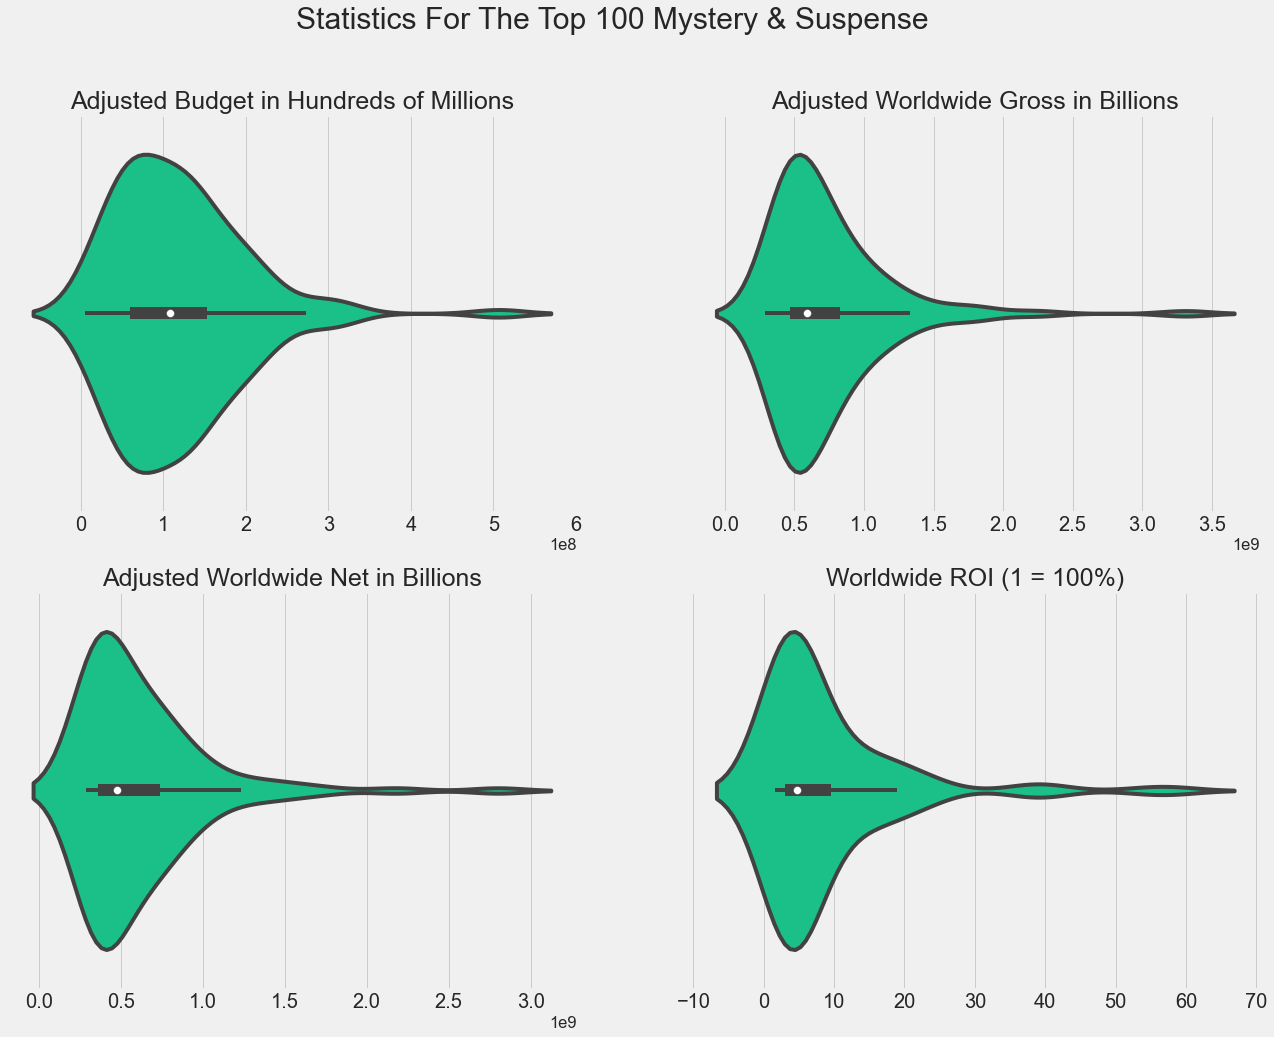

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=mystery)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=mystery)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=mystery)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=mystery)
fig.suptitle('Statistics For The Top 100 Mystery & Suspense', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

## Hidden Value Genres

In [173]:
drama.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   1998.380000       8.799077e+07     5.538411e+08      14.585568   
std      16.898855       7.220352e+07     3.532062e+08      30.676928   
min    1956.000000       7.770000e+05     6.000000e+07       1.572574   
25%    1988.750000       1.910000e+07     3.167676e+08       4.019681   
50%    2001.500000       7.965000e+07     4.775737e+08       5.810391   
75%    2012.250000       1.500000e+08     7.599021e+08      13.108057   
max    2018.000000       2.750000e+08     2.208208e+09     224.000000   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.196164e+08  8.575911e+08  7.379747e+08   14.585568  
std     7.573288e+07  4.367183e+08  4.166558e+08   30.676928  
min     4.473998e+06  4.190149e+08  3.933203e+08    1.572574  
25%     5.550426e+07  5.936157e+08  4.819644e+08    4.019681  
50%     1.194103e+08  7.508345e+08  6.496895e+08    5.810391  
75%     1.743389e+08  9.690354e+08  8.245330e+08   13.108057  
max     3.185757e+08  3.517408e+09  3.198832e+09  224.000000

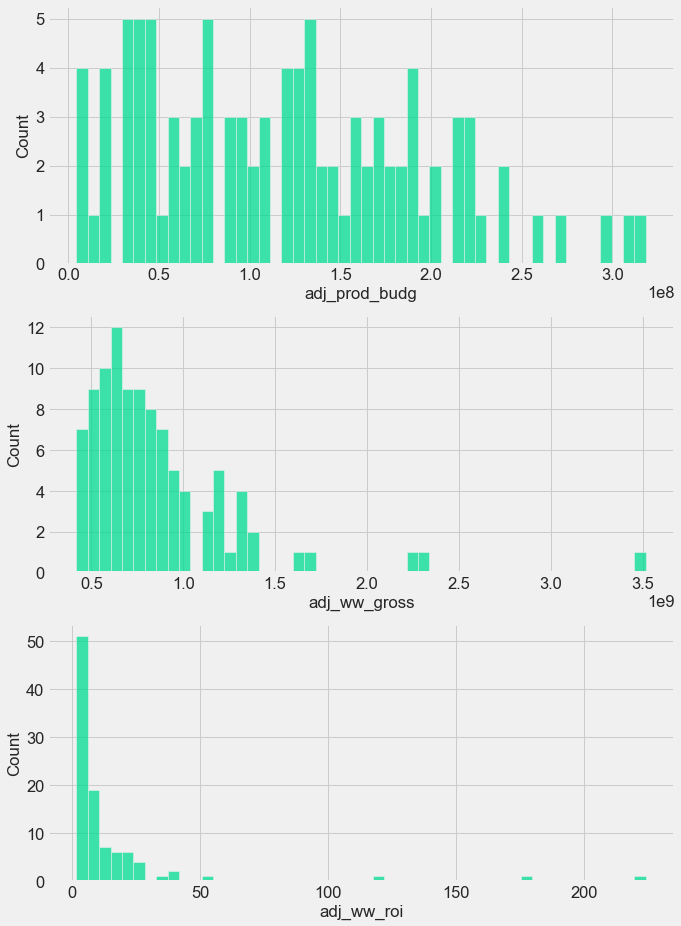

In [174]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(drama.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(drama.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(drama.adj_ww_roi, bins=50, ax=ax3)
plt.show()

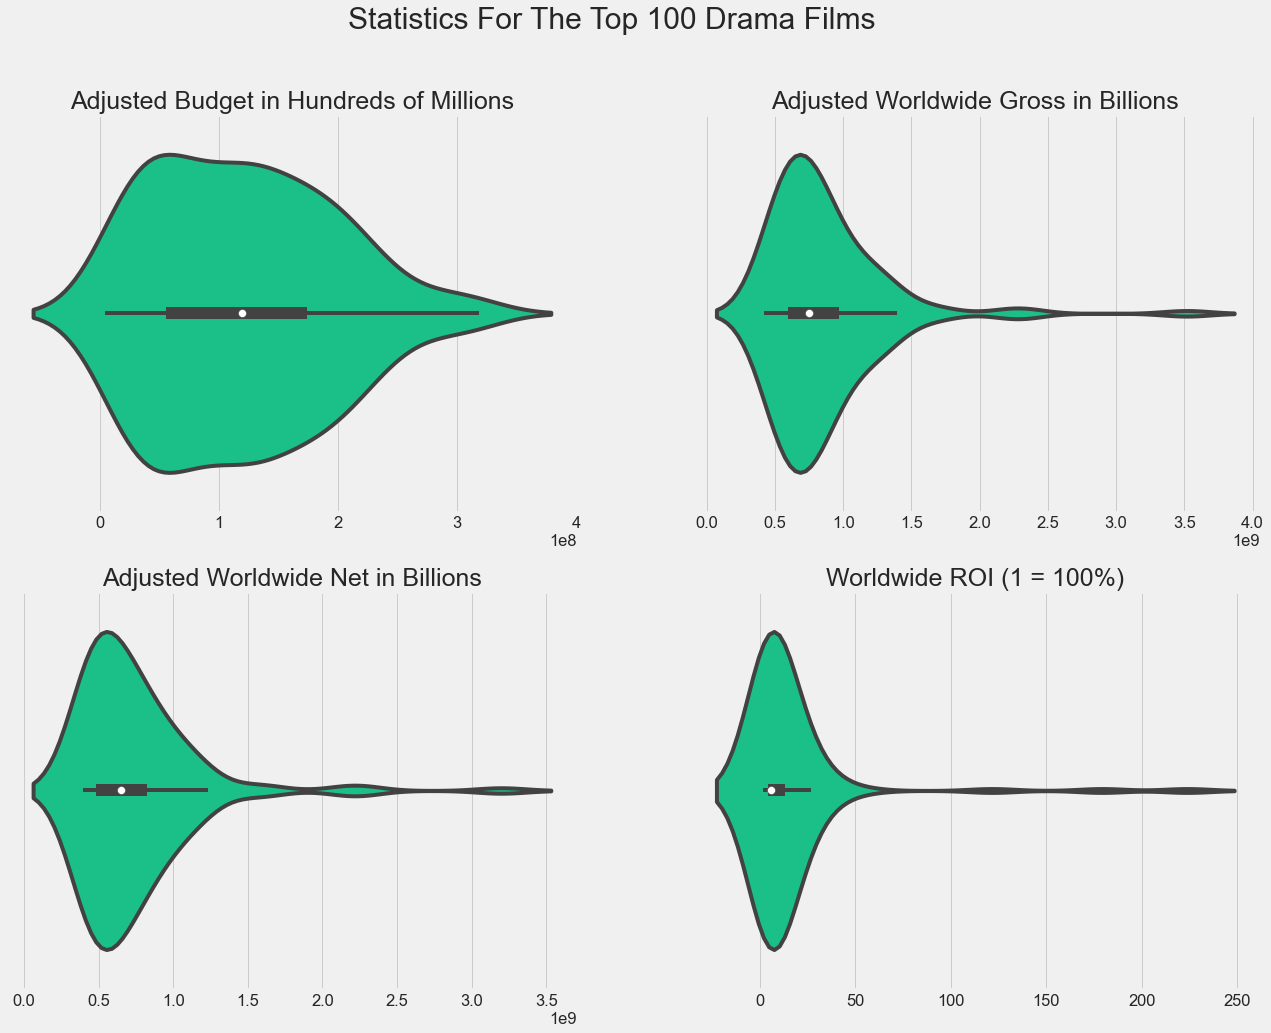

In [175]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=drama)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=drama)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=drama)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=drama)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')

plt.show()

In [176]:
comedy_df = dfr[(dfr['genres'].str.contains('comedy', case=False))]
unique_titles_c = comedy_df.drop_duplicates(subset = ['title'])
top100_comedy = unique_titles_c.sort_values(by='adj_ww_net', ascending=False).head(100)
comedy = top100_comedy[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [177]:
comedy.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   2001.640000       8.075577e+07     5.497952e+08      14.097429   
std      12.849966       7.391259e+07     3.374047e+08      21.906942   
min    1964.000000       7.770000e+05     8.050000e+07       1.546673   
25%    1994.000000       2.200000e+07     3.643412e+08       4.293940   
50%    2005.000000       6.950000e+07     5.139629e+08       7.037795   
75%    2011.000000       1.175000e+08     6.285260e+08      14.963399   
max    2018.000000       4.250000e+08     2.776345e+09     179.180180   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.016899e+08  7.668228e+08  6.651330e+08   14.097429  
std     8.150458e+07  3.480013e+08  3.085673e+08   21.906942  
min     4.473998e+06  4.161385e+08  3.992096e+08    1.546673  
25%     4.481536e+07  5.574747e+08  4.781795e+08    4.293940  
50%     8.206292e+07  6.801632e+08  5.863701e+08    7.037795  
75%     1.396775e+08  8.480253e+08  7.566582e+08   14.963399  
max     5.064591e+08  3.308483e+09  2.802024e+09  179.180180

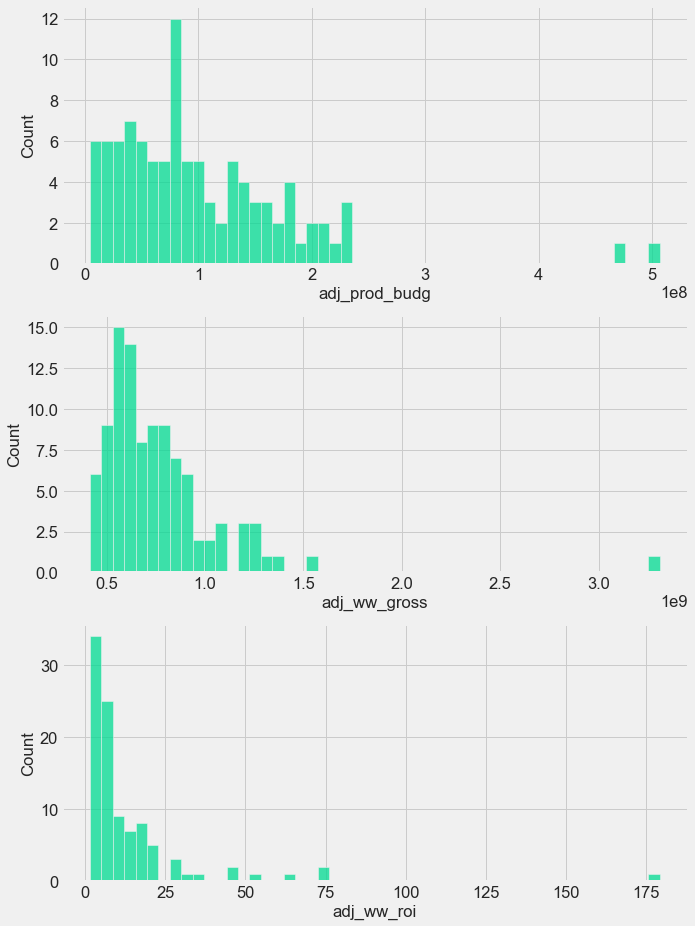

In [178]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(comedy.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(comedy.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(comedy.adj_ww_roi, bins=50, ax=ax3)
plt.show()

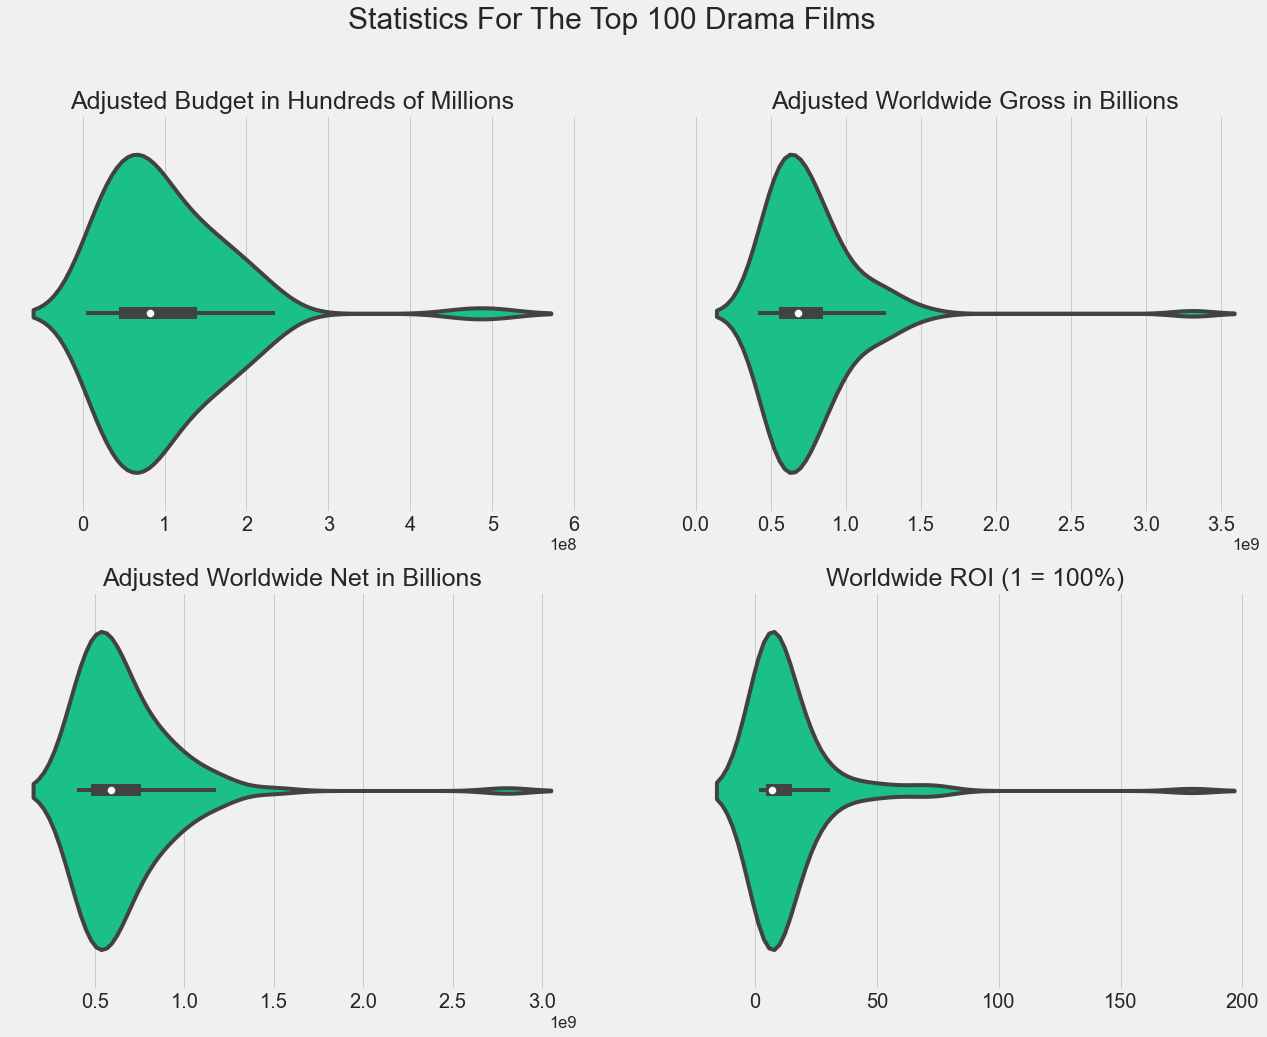

In [179]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=comedy)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=comedy)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=comedy)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=comedy)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [180]:
horror_df = dfr[(dfr['genres'].str.contains('horror', case=False))]
unique_titles_h = horror_df.drop_duplicates(subset = ['title'])
top100_horror = unique_titles_c.sort_values(by='adj_ww_net', ascending=False).head(100)
horror = top100_horror[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [181]:
horror.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   2001.640000       8.075577e+07     5.497952e+08      14.097429   
std      12.849966       7.391259e+07     3.374047e+08      21.906942   
min    1964.000000       7.770000e+05     8.050000e+07       1.546673   
25%    1994.000000       2.200000e+07     3.643412e+08       4.293940   
50%    2005.000000       6.950000e+07     5.139629e+08       7.037795   
75%    2011.000000       1.175000e+08     6.285260e+08      14.963399   
max    2018.000000       4.250000e+08     2.776345e+09     179.180180   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.016899e+08  7.668228e+08  6.651330e+08   14.097429  
std     8.150458e+07  3.480013e+08  3.085673e+08   21.906942  
min     4.473998e+06  4.161385e+08  3.992096e+08    1.546673  
25%     4.481536e+07  5.574747e+08  4.781795e+08    4.293940  
50%     8.206292e+07  6.801632e+08  5.863701e+08    7.037795  
75%     1.396775e+08  8.480253e+08  7.566582e+08   14.963399  
max     5.064591e+08  3.308483e+09  2.802024e+09  179.180180

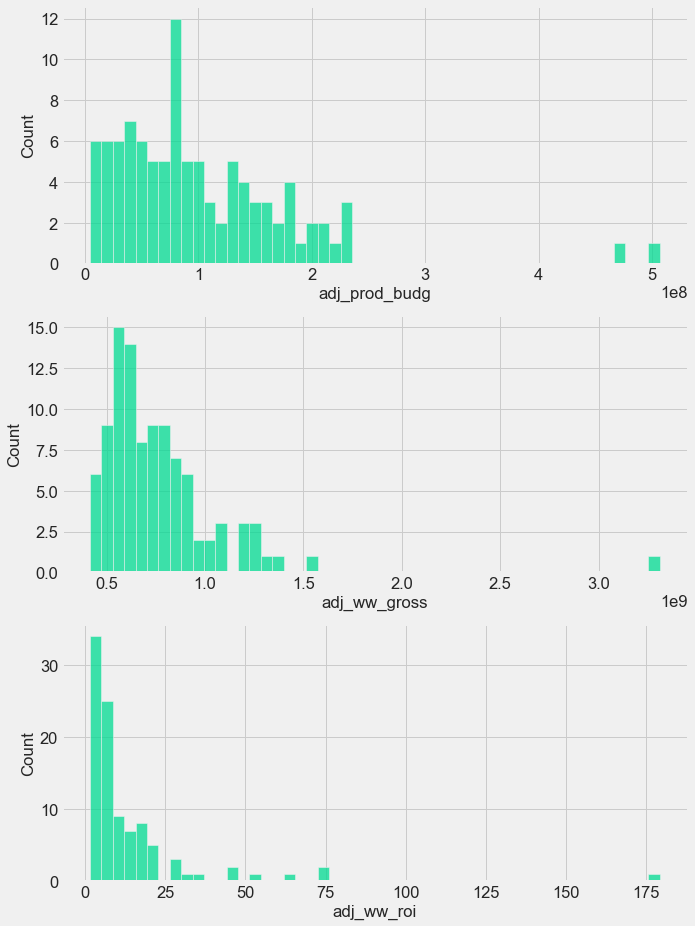

In [182]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(horror.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(horror.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(horror.adj_ww_roi, bins=50, ax=ax3)
plt.show()

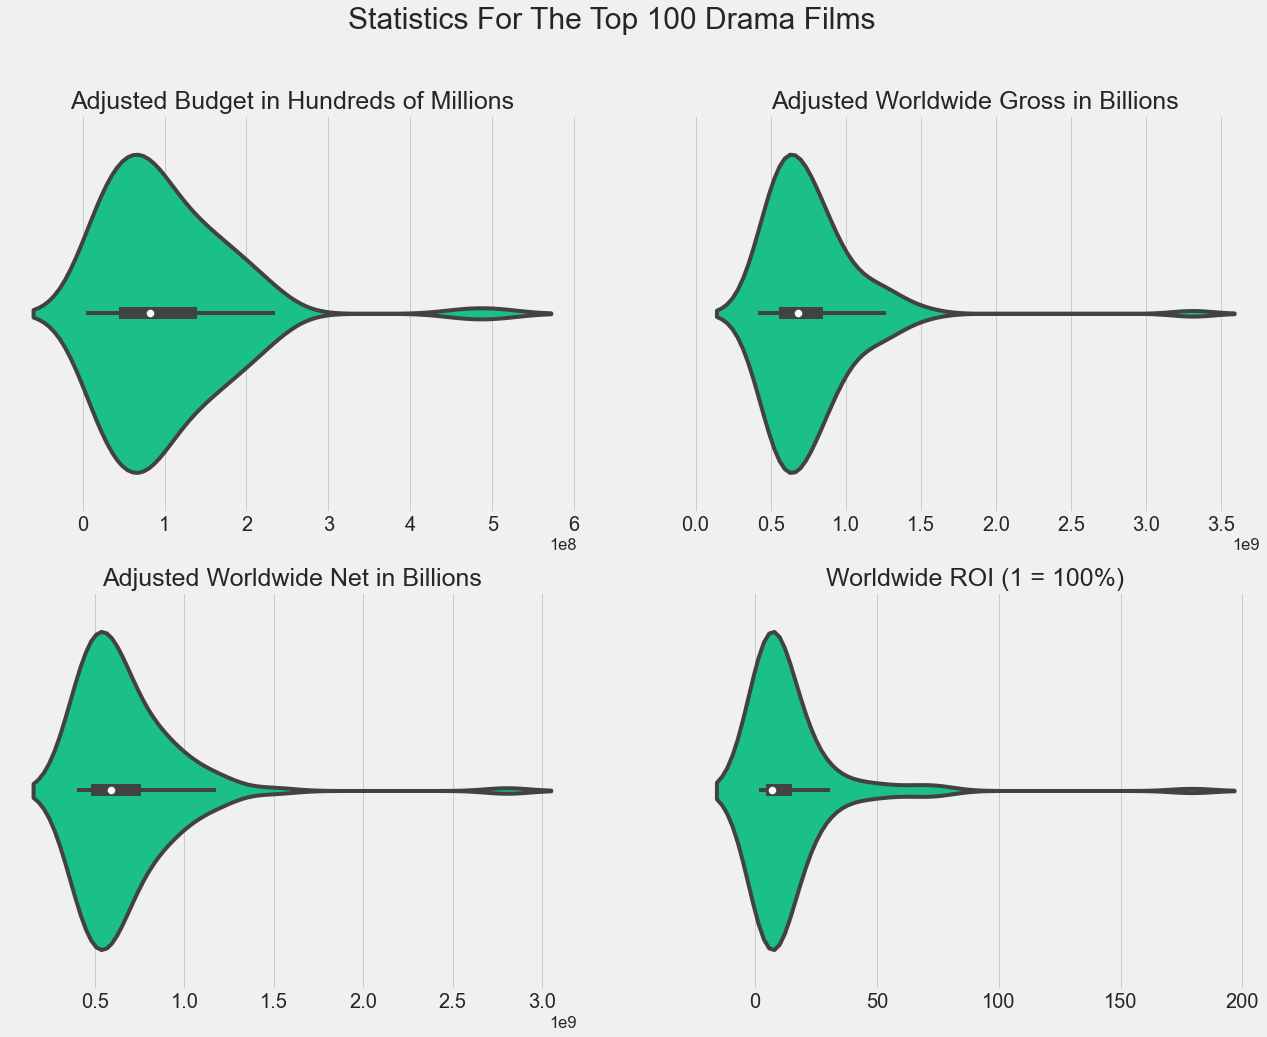

In [183]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=horror)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=horror)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=horror)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=horror)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [184]:
mystery.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.00000       1.000000e+02     1.000000e+02     100.000000   
mean   1998.16000       8.399603e+07     4.702527e+08       8.815051   
std      14.42341       7.249287e+07     3.753899e+08      10.409541   
min    1963.00000       1.000000e+06     5.956704e+07       1.572574   
25%    1990.00000       2.950000e+07     2.665057e+08       3.015911   
50%    2001.00000       7.285131e+07     3.609445e+08       4.747841   
75%    2009.00000       1.250000e+08     5.550299e+08       9.558434   
max    2018.00000       4.250000e+08     2.776345e+09      58.567035   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    1.176330e+08  7.335896e+08  6.159566e+08    8.815051  
std     7.914311e+07  4.391955e+08  4.035152e+08   10.409541  
min     5.214936e+06  2.909567e+08  2.845317e+08    1.572574  
25%     5.945324e+07  4.707996e+08  3.622374e+08    3.015911  
50%     1.082075e+08  5.938407e+08  4.751254e+08    4.747841  
75%     1.528633e+08  8.280635e+08  7.408709e+08    9.558434  
max     5.064591e+08  3.308483e+09  2.802024e+09   58.567035

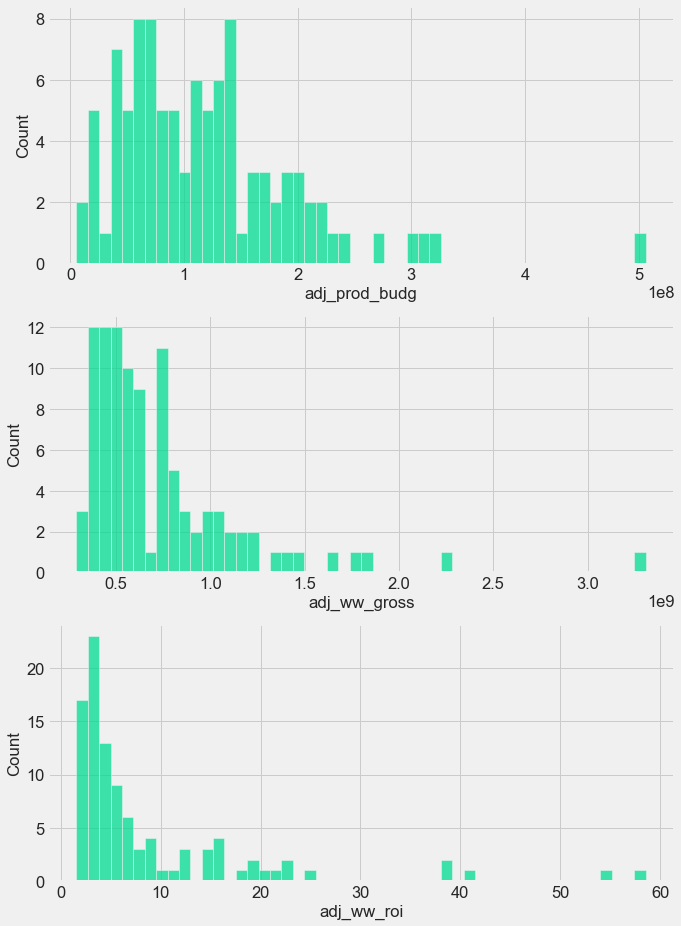

In [185]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(mystery.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(mystery.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(mystery.adj_ww_roi, bins=50, ax=ax3)
plt.show()

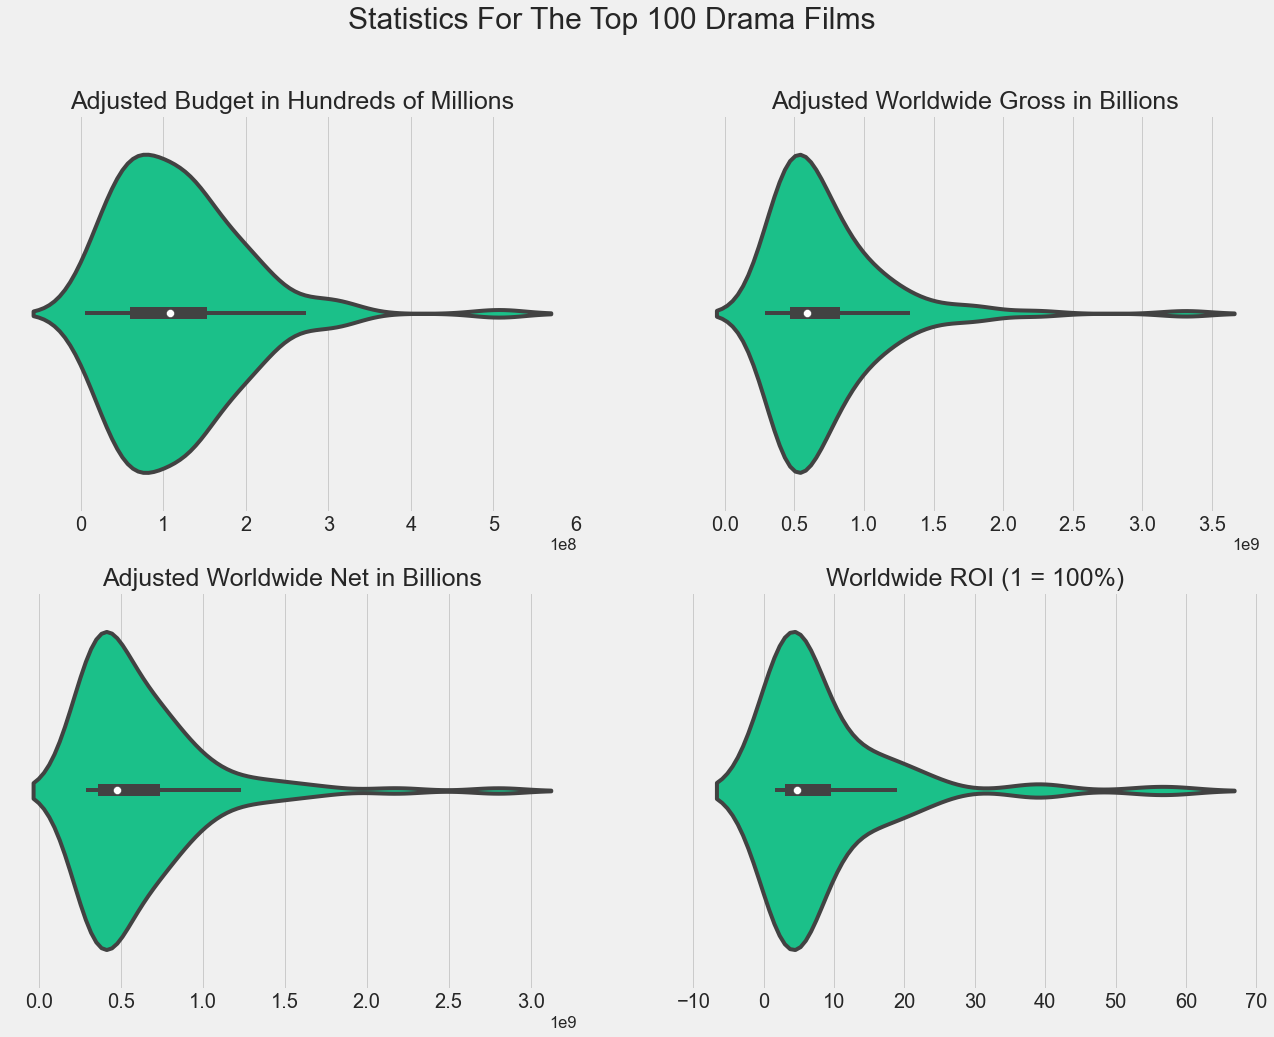

In [186]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=mystery)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=mystery)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=mystery)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=mystery)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [187]:
classics_df = dfr[(dfr['genres'].str.contains('classics', case=False))]
unique_titles_cl = classics_df.drop_duplicates(subset = ['title'])
top100_classics = unique_titles_cl.sort_values(by='adj_ww_net', ascending=False).head(100)
classics = top100_classics[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_roi', 'adj_prod_budg', 'adj_ww_gross', 'adj_ww_net', 'adj_ww_roi']]

In [188]:
classics.describe()

year  production_budget  worldwide_gross  worldwide_roi  \
count   100.000000       1.000000e+02     1.000000e+02     100.000000   
mean   1980.100000       4.259367e+07     2.125317e+08      15.284037   
std      22.943277       5.247925e+07     2.995271e+08      36.392485   
min    1925.000000       2.450000e+05     9.600000e+06       0.654468   
25%    1963.000000       3.150000e+06     4.166470e+07       2.561874   
50%    1974.000000       1.200000e+07     1.177500e+08       5.092629   
75%    2002.000000       7.625000e+07     2.562077e+08      11.375146   
max    2017.000000       2.070000e+08     2.208208e+09     311.354312   

       adj_prod_budg  adj_ww_gross    adj_ww_net  adj_ww_roi  
count   1.000000e+02  1.000000e+02  1.000000e+02  100.000000  
mean    7.956313e+07  5.812857e+08  5.017226e+08   15.284037  
std     6.750033e+07  6.783062e+08  6.679776e+08   36.392485  
min     3.579198e+06  9.123819e+07  8.170481e+07    0.654468  
25%     2.629121e+07  2.542347e+08  1.599581e+08    2.561874  
50%     6.612472e+07  3.489946e+08  2.919051e+08    5.092629  
75%     1.227645e+08  6.329666e+08  5.150070e+08   11.375146  
max     3.509018e+08  4.203440e+09  4.189983e+09  311.354312

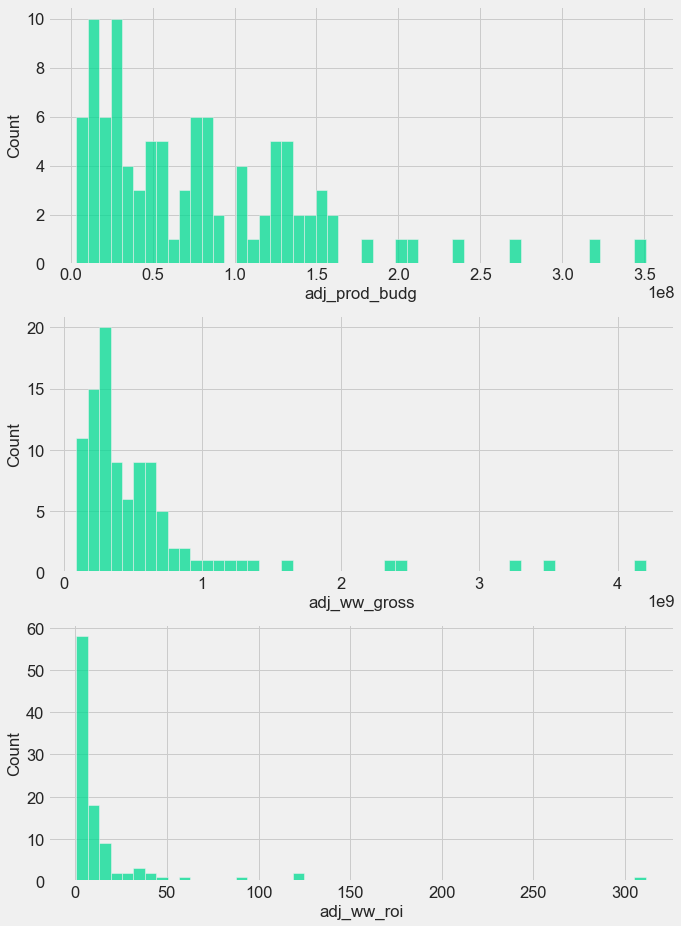

In [189]:
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, figsize=(10,15))
sns.histplot(classics.adj_prod_budg, bins=50, ax=ax1)
sns.histplot(classics.adj_ww_gross, bins=50, ax=ax2)
sns.histplot(classics.adj_ww_roi, bins=50, ax=ax3)
plt.show()

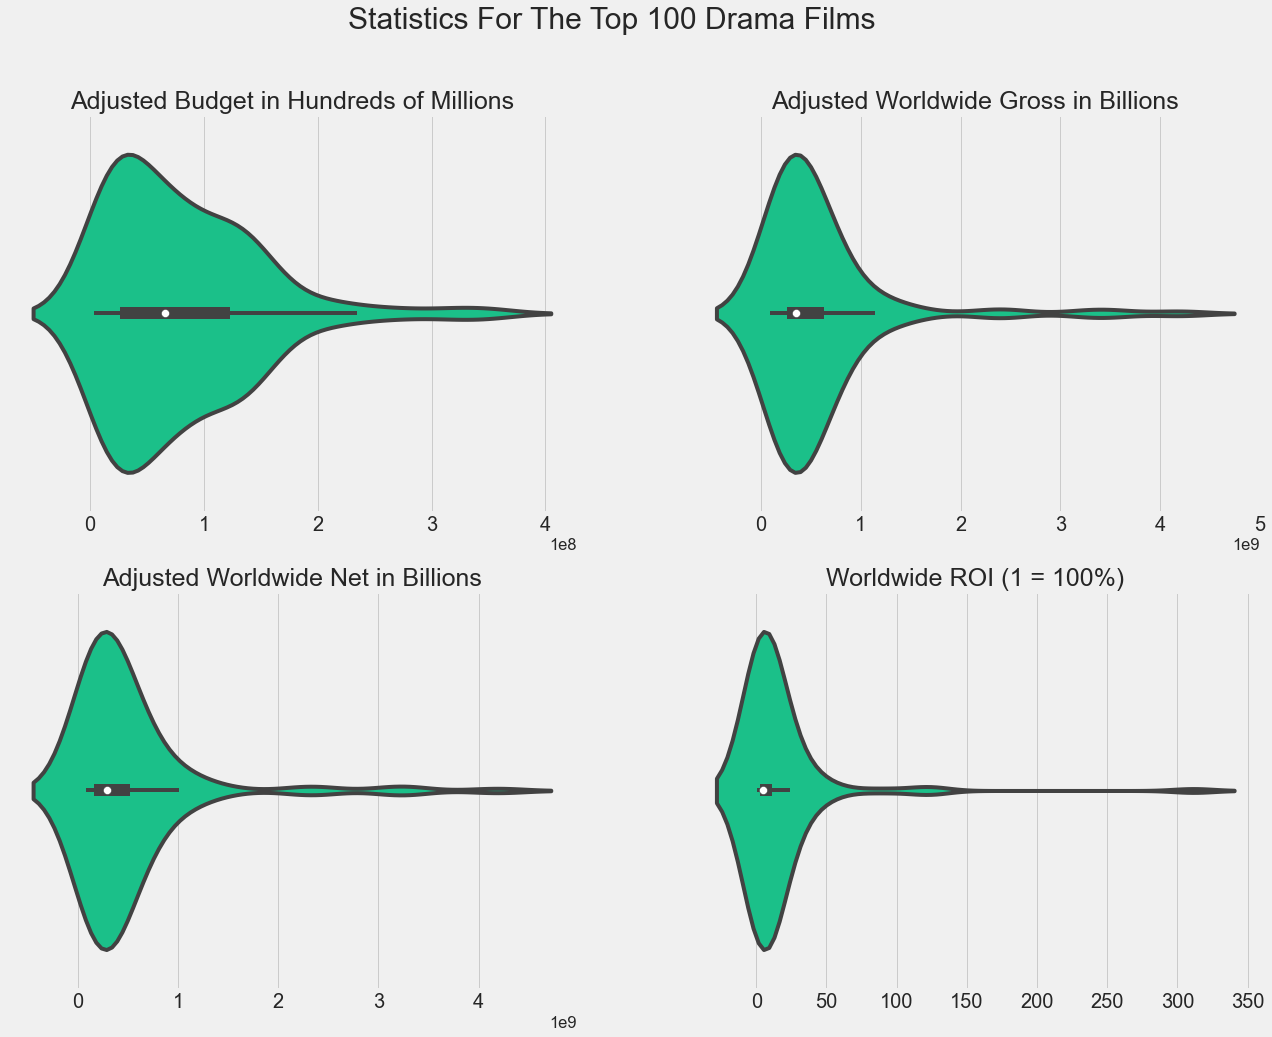

In [190]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=classics)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=classics)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=classics)
sns.violinplot(ax=axes[1, 1], x='adj_ww_roi', data=classics)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Adjusted Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Adjusted Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Adjusted Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [191]:
f = list(family.title)
cl = list(classics.title)

overlap = [i for i in f + cl if i in f and i in cl]
overlap

['Bambi',
 'Snow White and the Seven Dwarfs',
 'The Sound of Music',
 'Alice in Wonderland',
 'Mary Poppins',
 'The Wizard of Oz',
 'Cinderella',
 'Fiddler on the Roof',
 'The Hunchback of Notre Dame',
 'Doctor Dolittle',
 'How the Grinch Stole Christmas',
 'The Greatest Show on Earth',
 'Bambi',
 'Snow White and the Seven Dwarfs',
 'The Sound of Music',
 'Alice in Wonderland',
 'Mary Poppins',
 'The Wizard of Oz',
 'Cinderella',
 'Fiddler on the Roof',
 'The Hunchback of Notre Dame',
 'Doctor Dolittle',
 'How the Grinch Stole Christmas',
 'The Greatest Show on Earth']